In [508]:
# Importing necessary libraries and packages
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import statsmodels.api as sm
import tensorflow as tf
import xgboost as xgb
import os
import warnings
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.metrics import mean_squared_error
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/weather-data/finWeatherData.csv
/kaggle/input/power-demand-data/demand_Data.csv


In [509]:
# Reading the demand data 
df_weather =  pd.read_csv("/kaggle/input/weather-data/finWeatherData.csv",index_col = 0,parse_dates=True)

In [510]:
# show the first five rows of demand data
df_weather.head()

Date       Tmax       Tmin  Rain
0  2019-01-01  28.696802  14.070121   0.0
1  2019-01-02  29.149151  14.778795   0.0
2  2019-01-03  29.741541  15.863366   0.0
3  2019-01-04  29.451434  16.492335   0.0
4  2019-01-05  28.863384  16.951641   0.0

In [511]:
# Reading the demand data 
df_demand = pd.read_csv("/kaggle/input/power-demand-data/demand_Data.csv",parse_dates =True)

In [512]:
# show the first five rows of demand data
df_demand.head()

Date  Energy Required (MU)
0  02-May-12               255.639
1  03-May-12               258.470
2  04-May-12               261.393
3  05-May-12               252.866
4  06-May-12               250.566

In [513]:

# Convert the date column to datetime format
df_demand['Date'] = pd.to_datetime(df_demand['Date'],errors="coerce", format="%d-%b-%y")

# Convert the date column to the desired format
df_demand['Date'] = df_demand['Date'].dt.strftime("%Y/%m/%d")

In [514]:
df_demand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3942 entries, 0 to 3941
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  3939 non-null   object 
 1   Energy Required (MU)  3940 non-null   float64
dtypes: float64(1), object(1)
memory usage: 61.7+ KB


There are **null values** in demand data

In [452]:

# Convert the "Date" column in df_energy to datetime format
df_demand['Date'] = pd.to_datetime(df_demand['Date'])

# Filter df_energy to include dates starting from 01/01/2019
#df_demand = df_demand[df_demand['Date'] >= '2019-01-01']

# Convert the "Date" column in df_weather to datetime format
df_weather['Date'] = pd.to_datetime(df_weather['Date'])

# Filter df_weather to include dates starting from 01/01/2019
#df_demand = df_demand[df_demand['Date'] >= '2019-01-01']

# Merge the two DataFrames based on the "Date" column
merged_df = pd.merge(df_demand, df_weather, on='Date', how='inner')


In [255]:
merged_df

Date  Energy Required (MU)       Tmax       Tmin      Rain
0    2019-01-01               152.233  28.696802  14.070121  0.000000
1    2019-01-02               155.343  29.149151  14.778795  0.000000
2    2019-01-03               157.659  29.741541  15.863366  0.000000
3    2019-01-04               159.317  29.451434  16.492335  0.000000
4    2019-01-05               159.691  28.863384  16.951641  0.000000
...         ...                   ...        ...        ...       ...
1588 2023-05-10               218.349  37.245505  26.819468  0.293171
1589 2023-05-11               219.604  37.272888  27.273576  0.000000
1590 2023-05-12               224.523  38.218507  26.842811  0.814892
1591 2023-05-13               224.030  38.145824  27.398606  0.000000
1592 2023-05-14               226.349  39.622750  27.568079  0.000000

[1593 rows x 5 columns]

In [256]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1593 entries, 0 to 1592
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  1593 non-null   datetime64[ns]
 1   Energy Required (MU)  1593 non-null   float64       
 2   Tmax                  1593 non-null   float64       
 3   Tmin                  1593 non-null   float64       
 4   Rain                  1593 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 74.7 KB


In [453]:
#creating a new feature as dayofweek
merged_df["Day"] = merged_df["Date"].dt.dayofweek

In [454]:
merged_df

Date  Energy Required (MU)       Tmax       Tmin      Rain  Day
0    2019-01-01               152.233  28.696802  14.070121  0.000000    1
1    2019-01-02               155.343  29.149151  14.778795  0.000000    2
2    2019-01-03               157.659  29.741541  15.863366  0.000000    3
3    2019-01-04               159.317  29.451434  16.492335  0.000000    4
4    2019-01-05               159.691  28.863384  16.951641  0.000000    5
...         ...                   ...        ...        ...       ...  ...
1588 2023-05-10               218.349  37.245505  26.819468  0.293171    2
1589 2023-05-11               219.604  37.272888  27.273576  0.000000    3
1590 2023-05-12               224.523  38.218507  26.842811  0.814892    4
1591 2023-05-13               224.030  38.145824  27.398606  0.000000    5
1592 2023-05-14               226.349  39.622750  27.568079  0.000000    6

[1593 rows x 6 columns]

In [455]:
#Set the date column as index for better access of time series data
merged_df = merged_df.set_index("Date")

In [456]:
merged_df.isna().sum()

Energy Required (MU)    0
Tmax                    0
Tmin                    0
Rain                    0
Day                     0
dtype: int64

No Null values present in the final dataframe

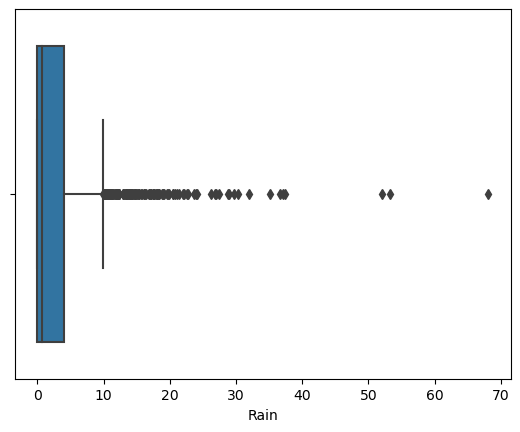

In [458]:
#plotting the boxplot for Rain column
sns.boxplot(x=merged_df['Rain'])
plt.show()

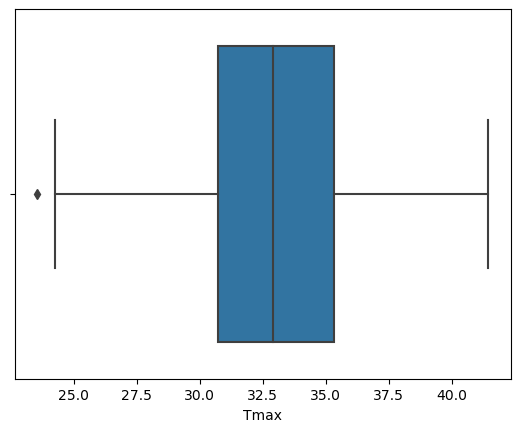

In [457]:
#plotting the boxplot for Tmax column
sns.boxplot(x=merged_df['Tmax'])
plt.show()

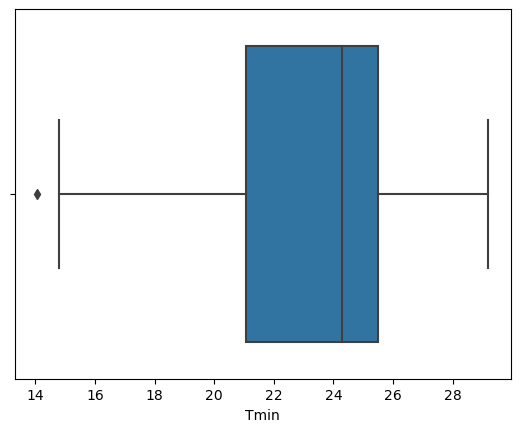

In [459]:
#plotting the boxplot for Tmin column
sns.boxplot(x=merged_df['Tmin'])
plt.show()

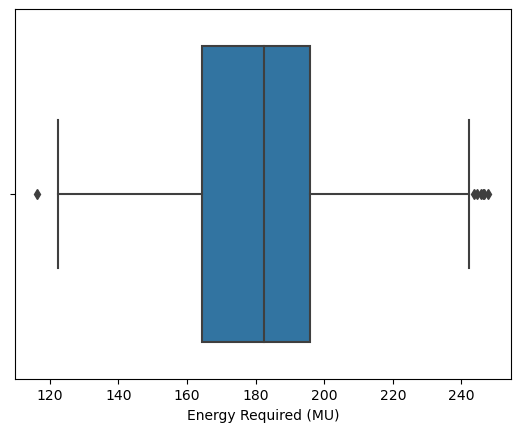

In [264]:
#plotting the boxplot for Energy demand column
sns.boxplot(x=merged_df['Energy Required (MU)'])
plt.show()

In [460]:
# Convert index to a DatetimeIndex with a frequency
merged_df.index = pd.date_range(start=merged_df.index[0], periods=len(merged_df), freq='D')

(array([17897., 18078., 18262., 18444., 18628., 18809., 18993., 19174.,
        19358., 19539.]),
 [Text(17897.0, 0, '2019-01'),
  Text(18078.0, 0, '2019-07'),
  Text(18262.0, 0, '2020-01'),
  Text(18444.0, 0, '2020-07'),
  Text(18628.0, 0, '2021-01'),
  Text(18809.0, 0, '2021-07'),
  Text(18993.0, 0, '2022-01'),
  Text(19174.0, 0, '2022-07'),
  Text(19358.0, 0, '2023-01'),
  Text(19539.0, 0, '2023-07')])

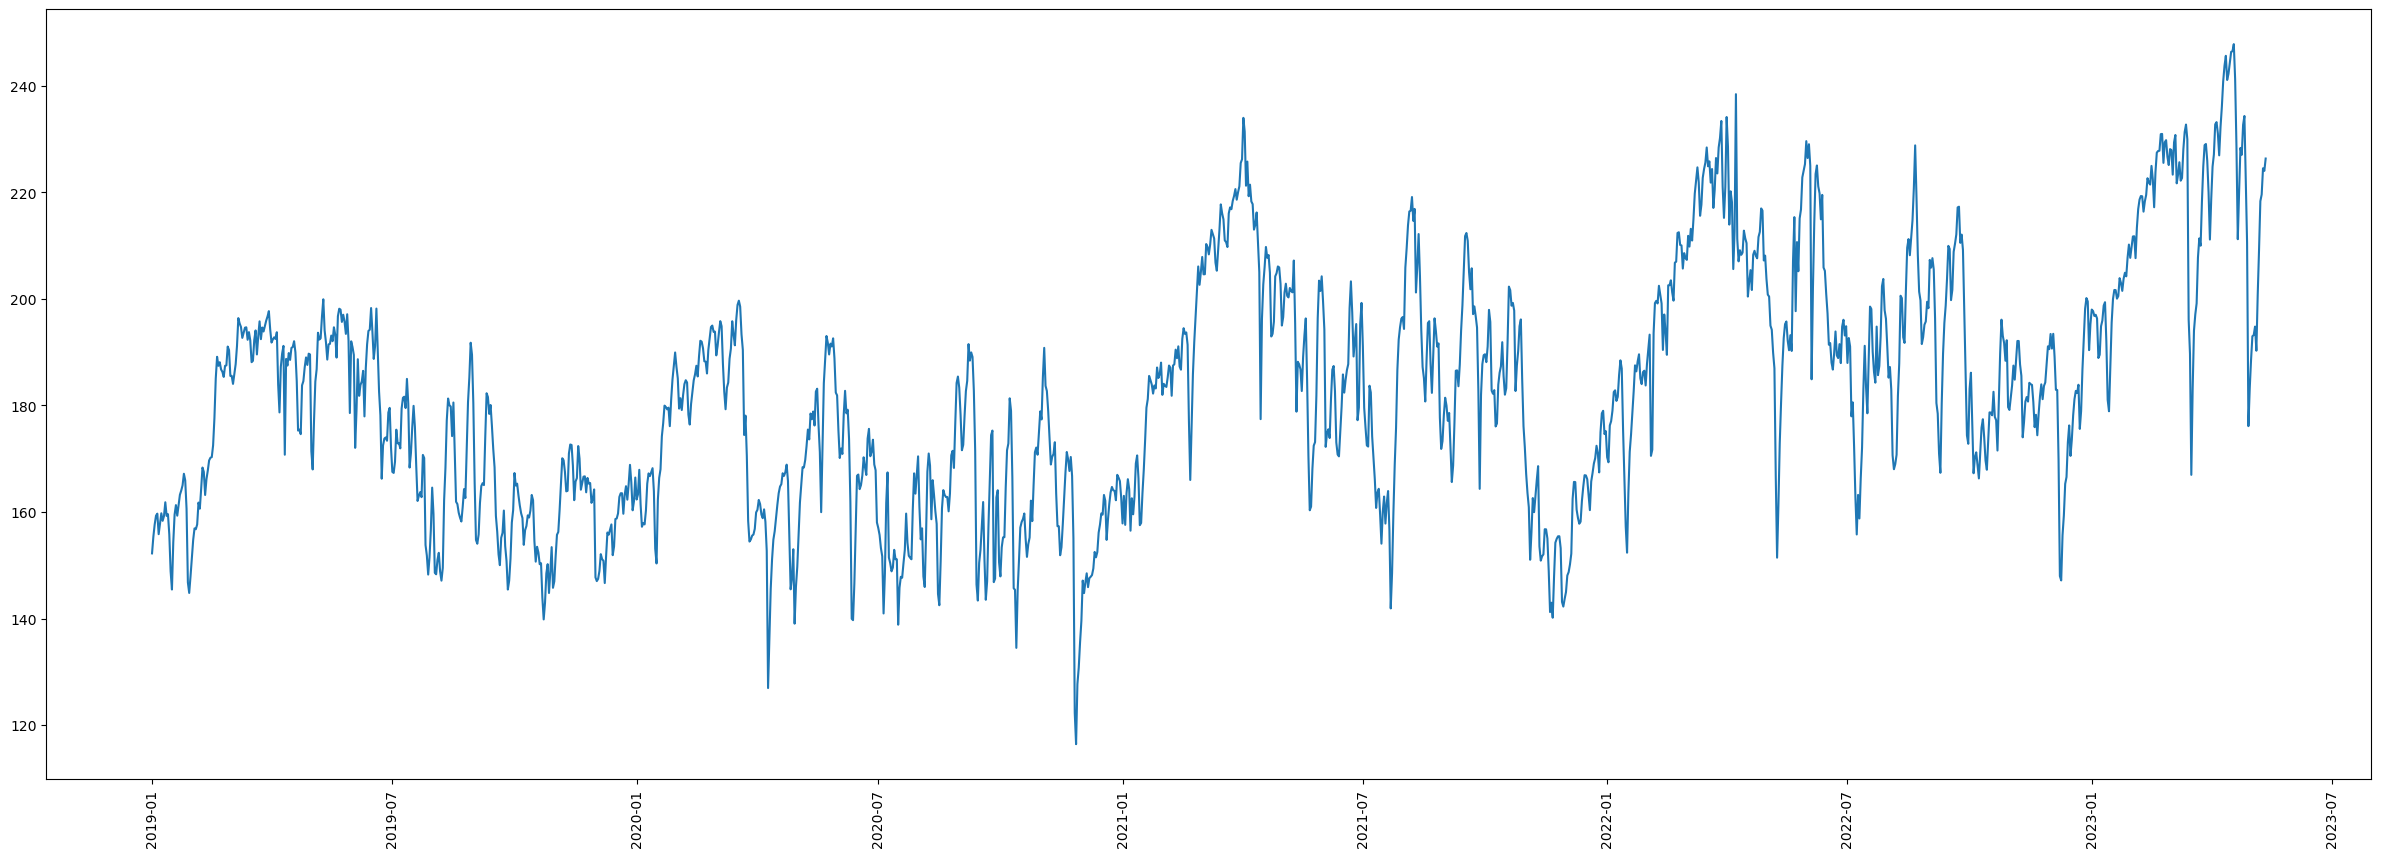

In [463]:
#plotting the Energy Required vs dates
plt.figure(figsize=(30,10))
plt.plot(merged_df["Energy Required (MU)"])
plt.xticks(rotation=90)

(array([17897., 18078., 18262., 18444., 18628., 18809., 18993., 19174.,
        19358., 19539.]),
 [Text(17897.0, 0, '2019-01'),
  Text(18078.0, 0, '2019-07'),
  Text(18262.0, 0, '2020-01'),
  Text(18444.0, 0, '2020-07'),
  Text(18628.0, 0, '2021-01'),
  Text(18809.0, 0, '2021-07'),
  Text(18993.0, 0, '2022-01'),
  Text(19174.0, 0, '2022-07'),
  Text(19358.0, 0, '2023-01'),
  Text(19539.0, 0, '2023-07')])

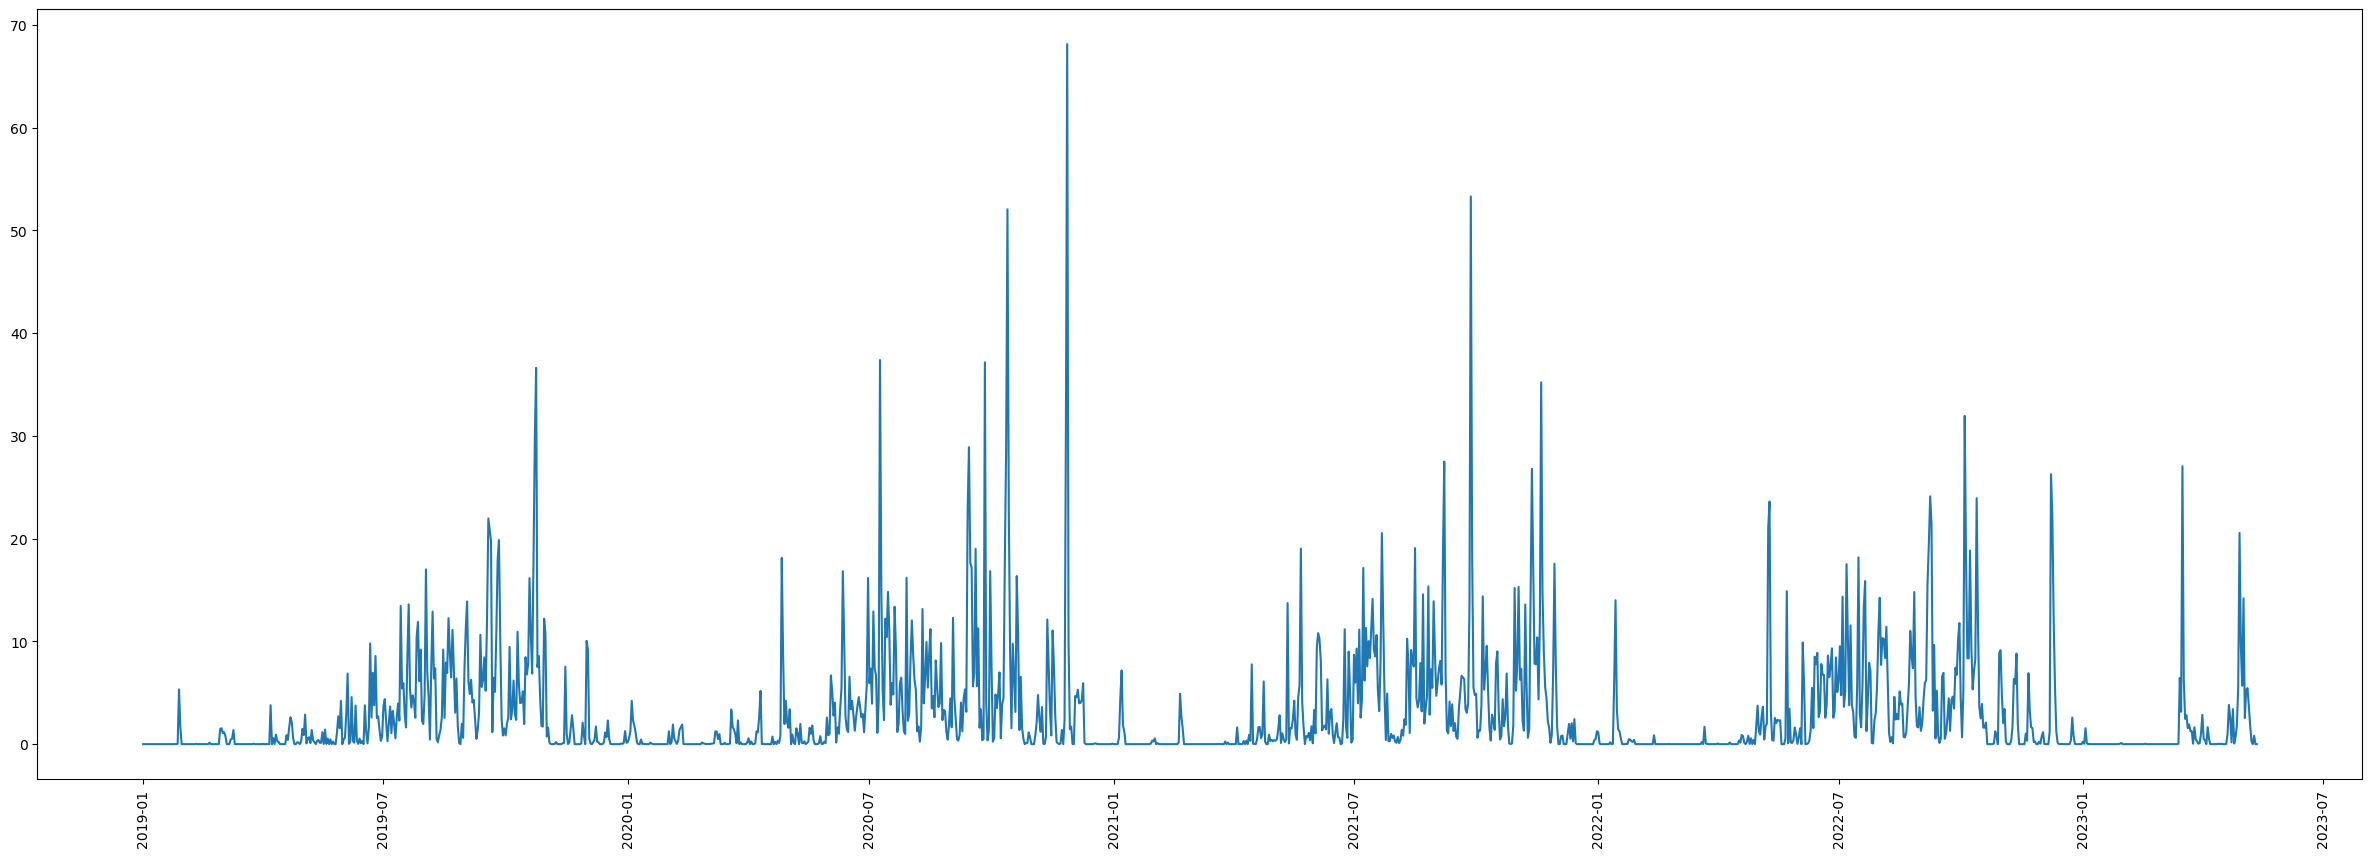

In [464]:
#Plotting rainfall vs date 
plt.figure(figsize=(30,10))
plt.plot(merged_df["Rain"])
plt.xticks(rotation=90)

(array([17897., 18078., 18262., 18444., 18628., 18809., 18993., 19174.,
        19358., 19539.]),
 [Text(17897.0, 0, '2019-01'),
  Text(18078.0, 0, '2019-07'),
  Text(18262.0, 0, '2020-01'),
  Text(18444.0, 0, '2020-07'),
  Text(18628.0, 0, '2021-01'),
  Text(18809.0, 0, '2021-07'),
  Text(18993.0, 0, '2022-01'),
  Text(19174.0, 0, '2022-07'),
  Text(19358.0, 0, '2023-01'),
  Text(19539.0, 0, '2023-07')])

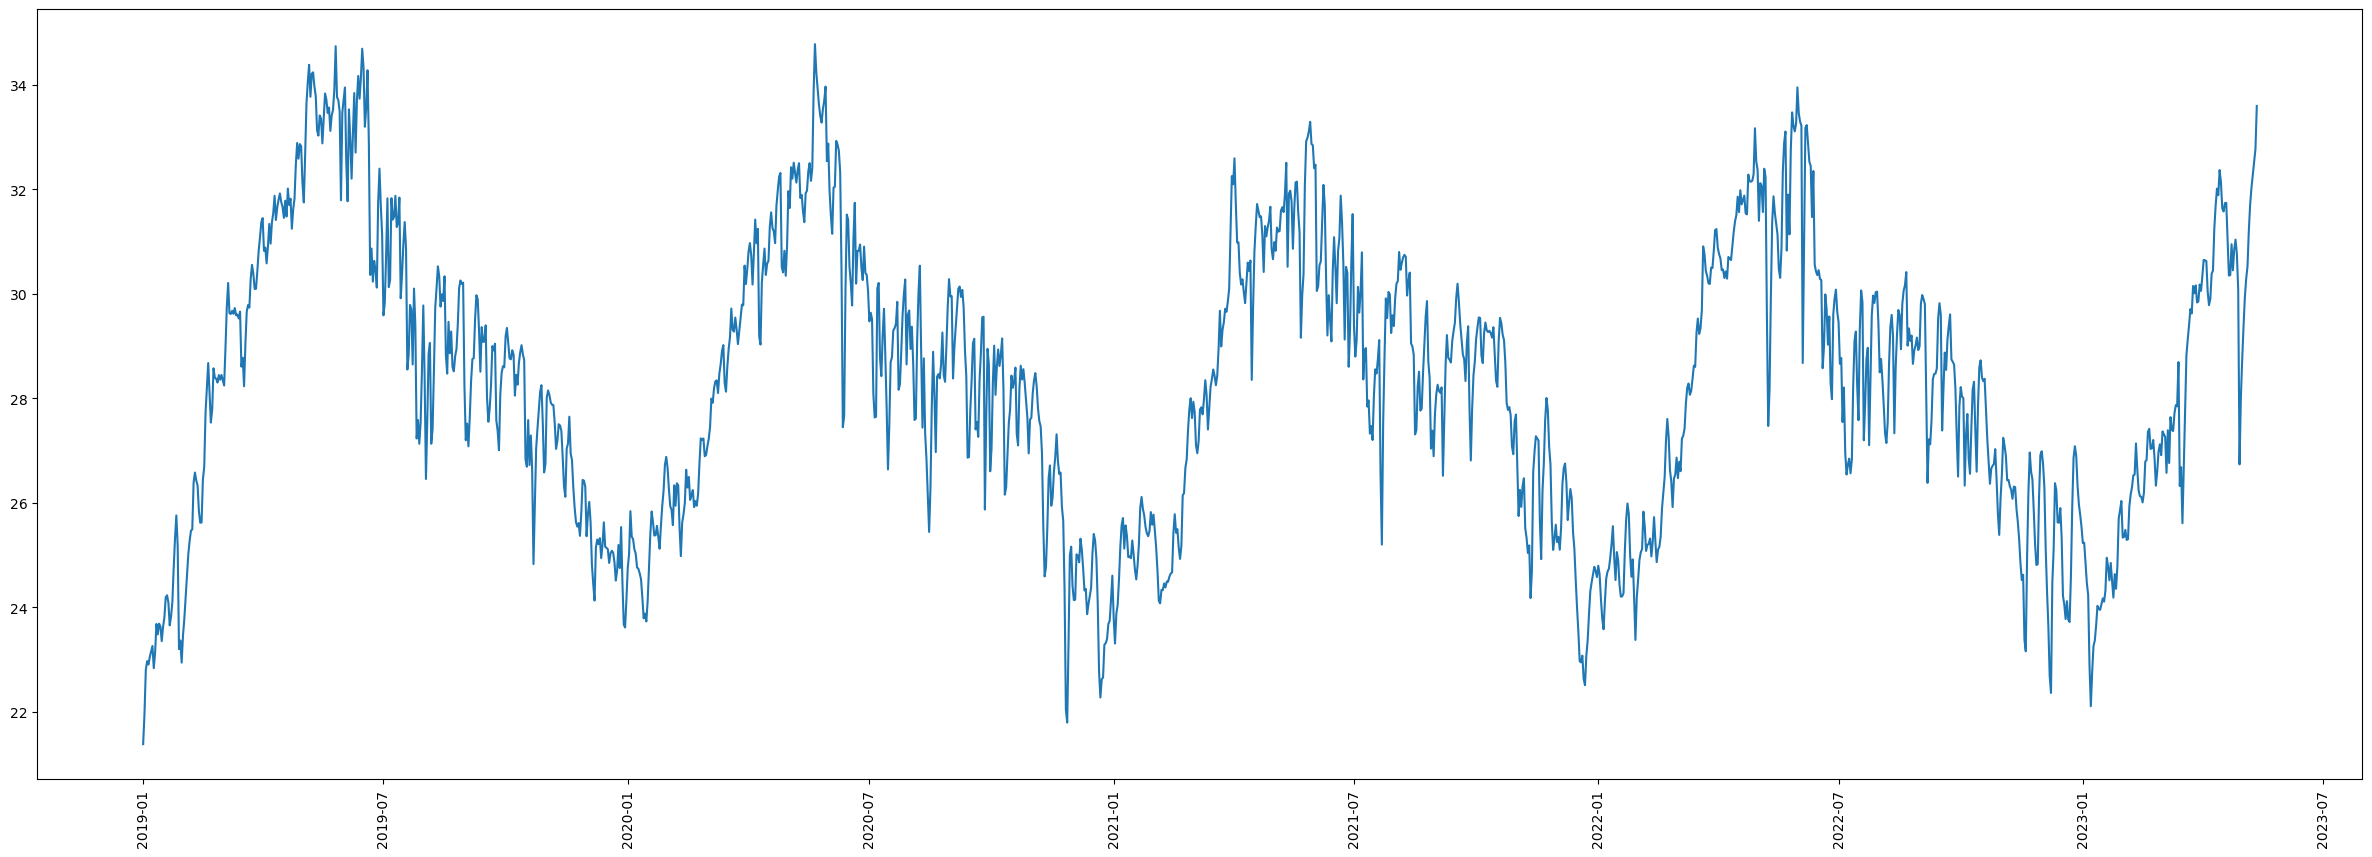

In [465]:
#plotting average temperature vs dates
plt.figure(figsize=(30,10))
plt.plot((merged_df["Tmax"]+merged_df["Tmin"])/2)
plt.xticks(rotation=90)

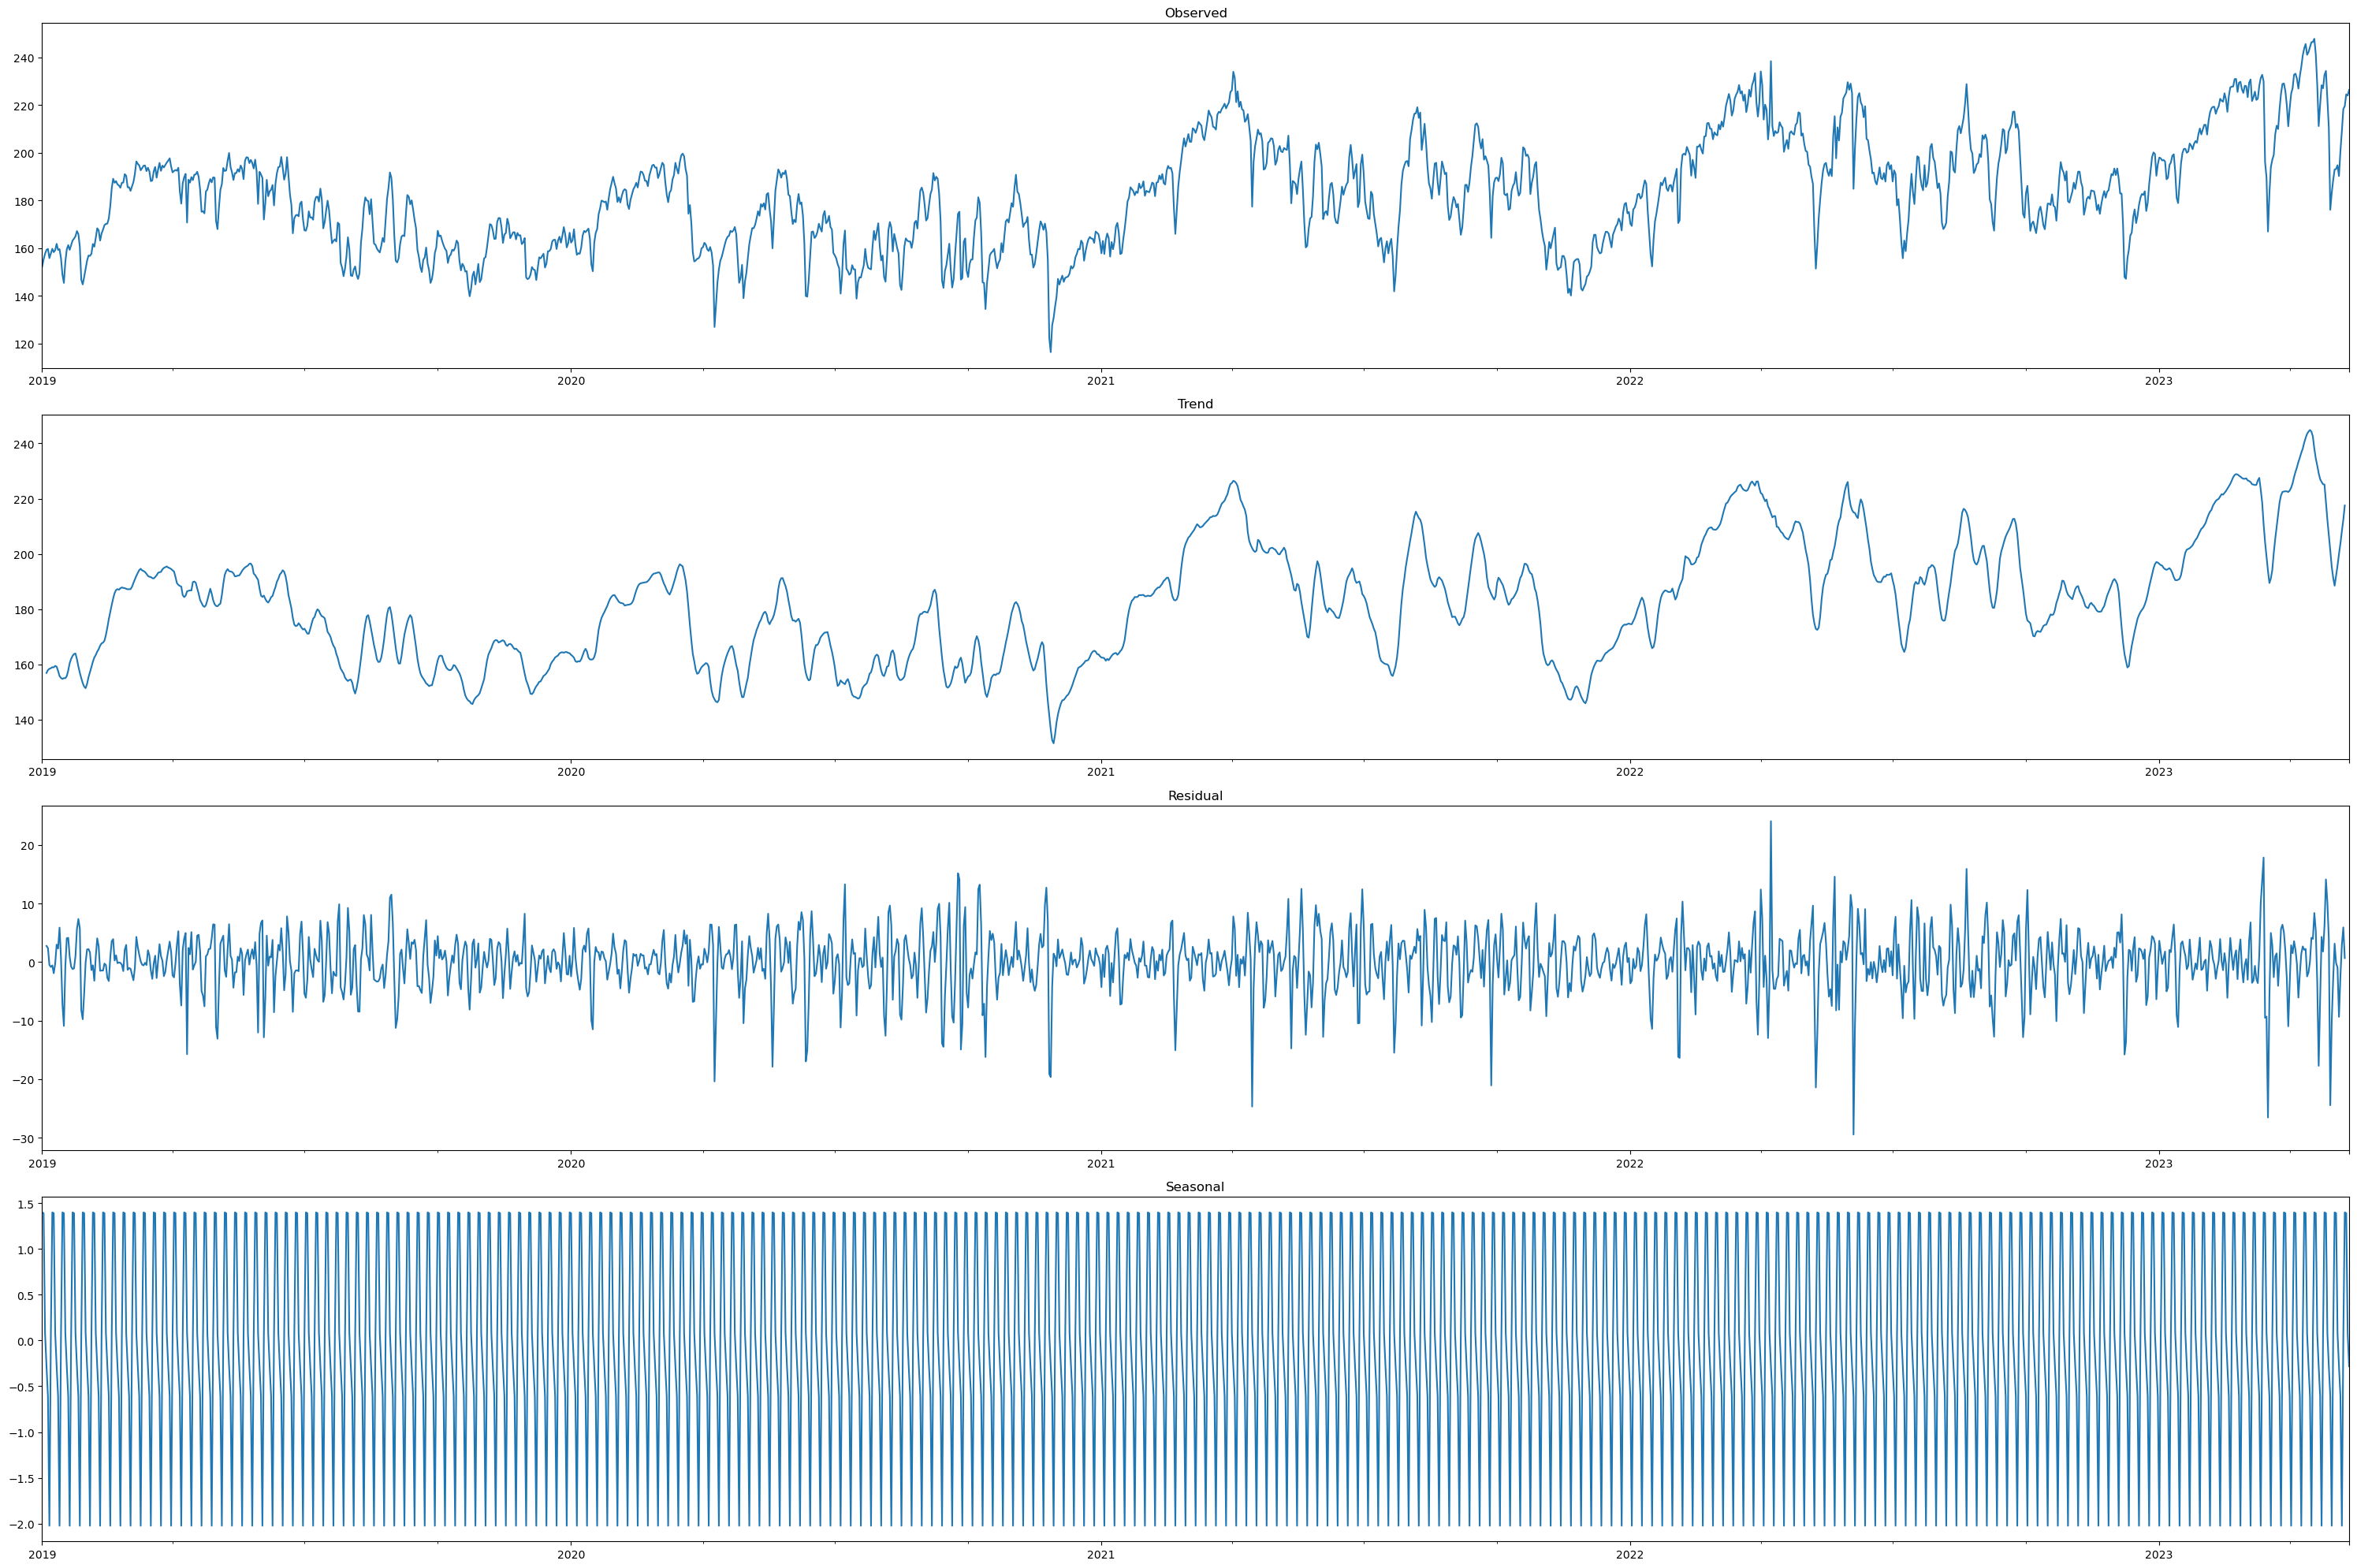

In [467]:
# Perform seasonal decomposition
res = sm.tsa.seasonal_decompose(merged_df['Energy Required (MU)'], model='additive')

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(30, 20))
res.observed.plot(ax=ax1, title='Observed')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
res.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()

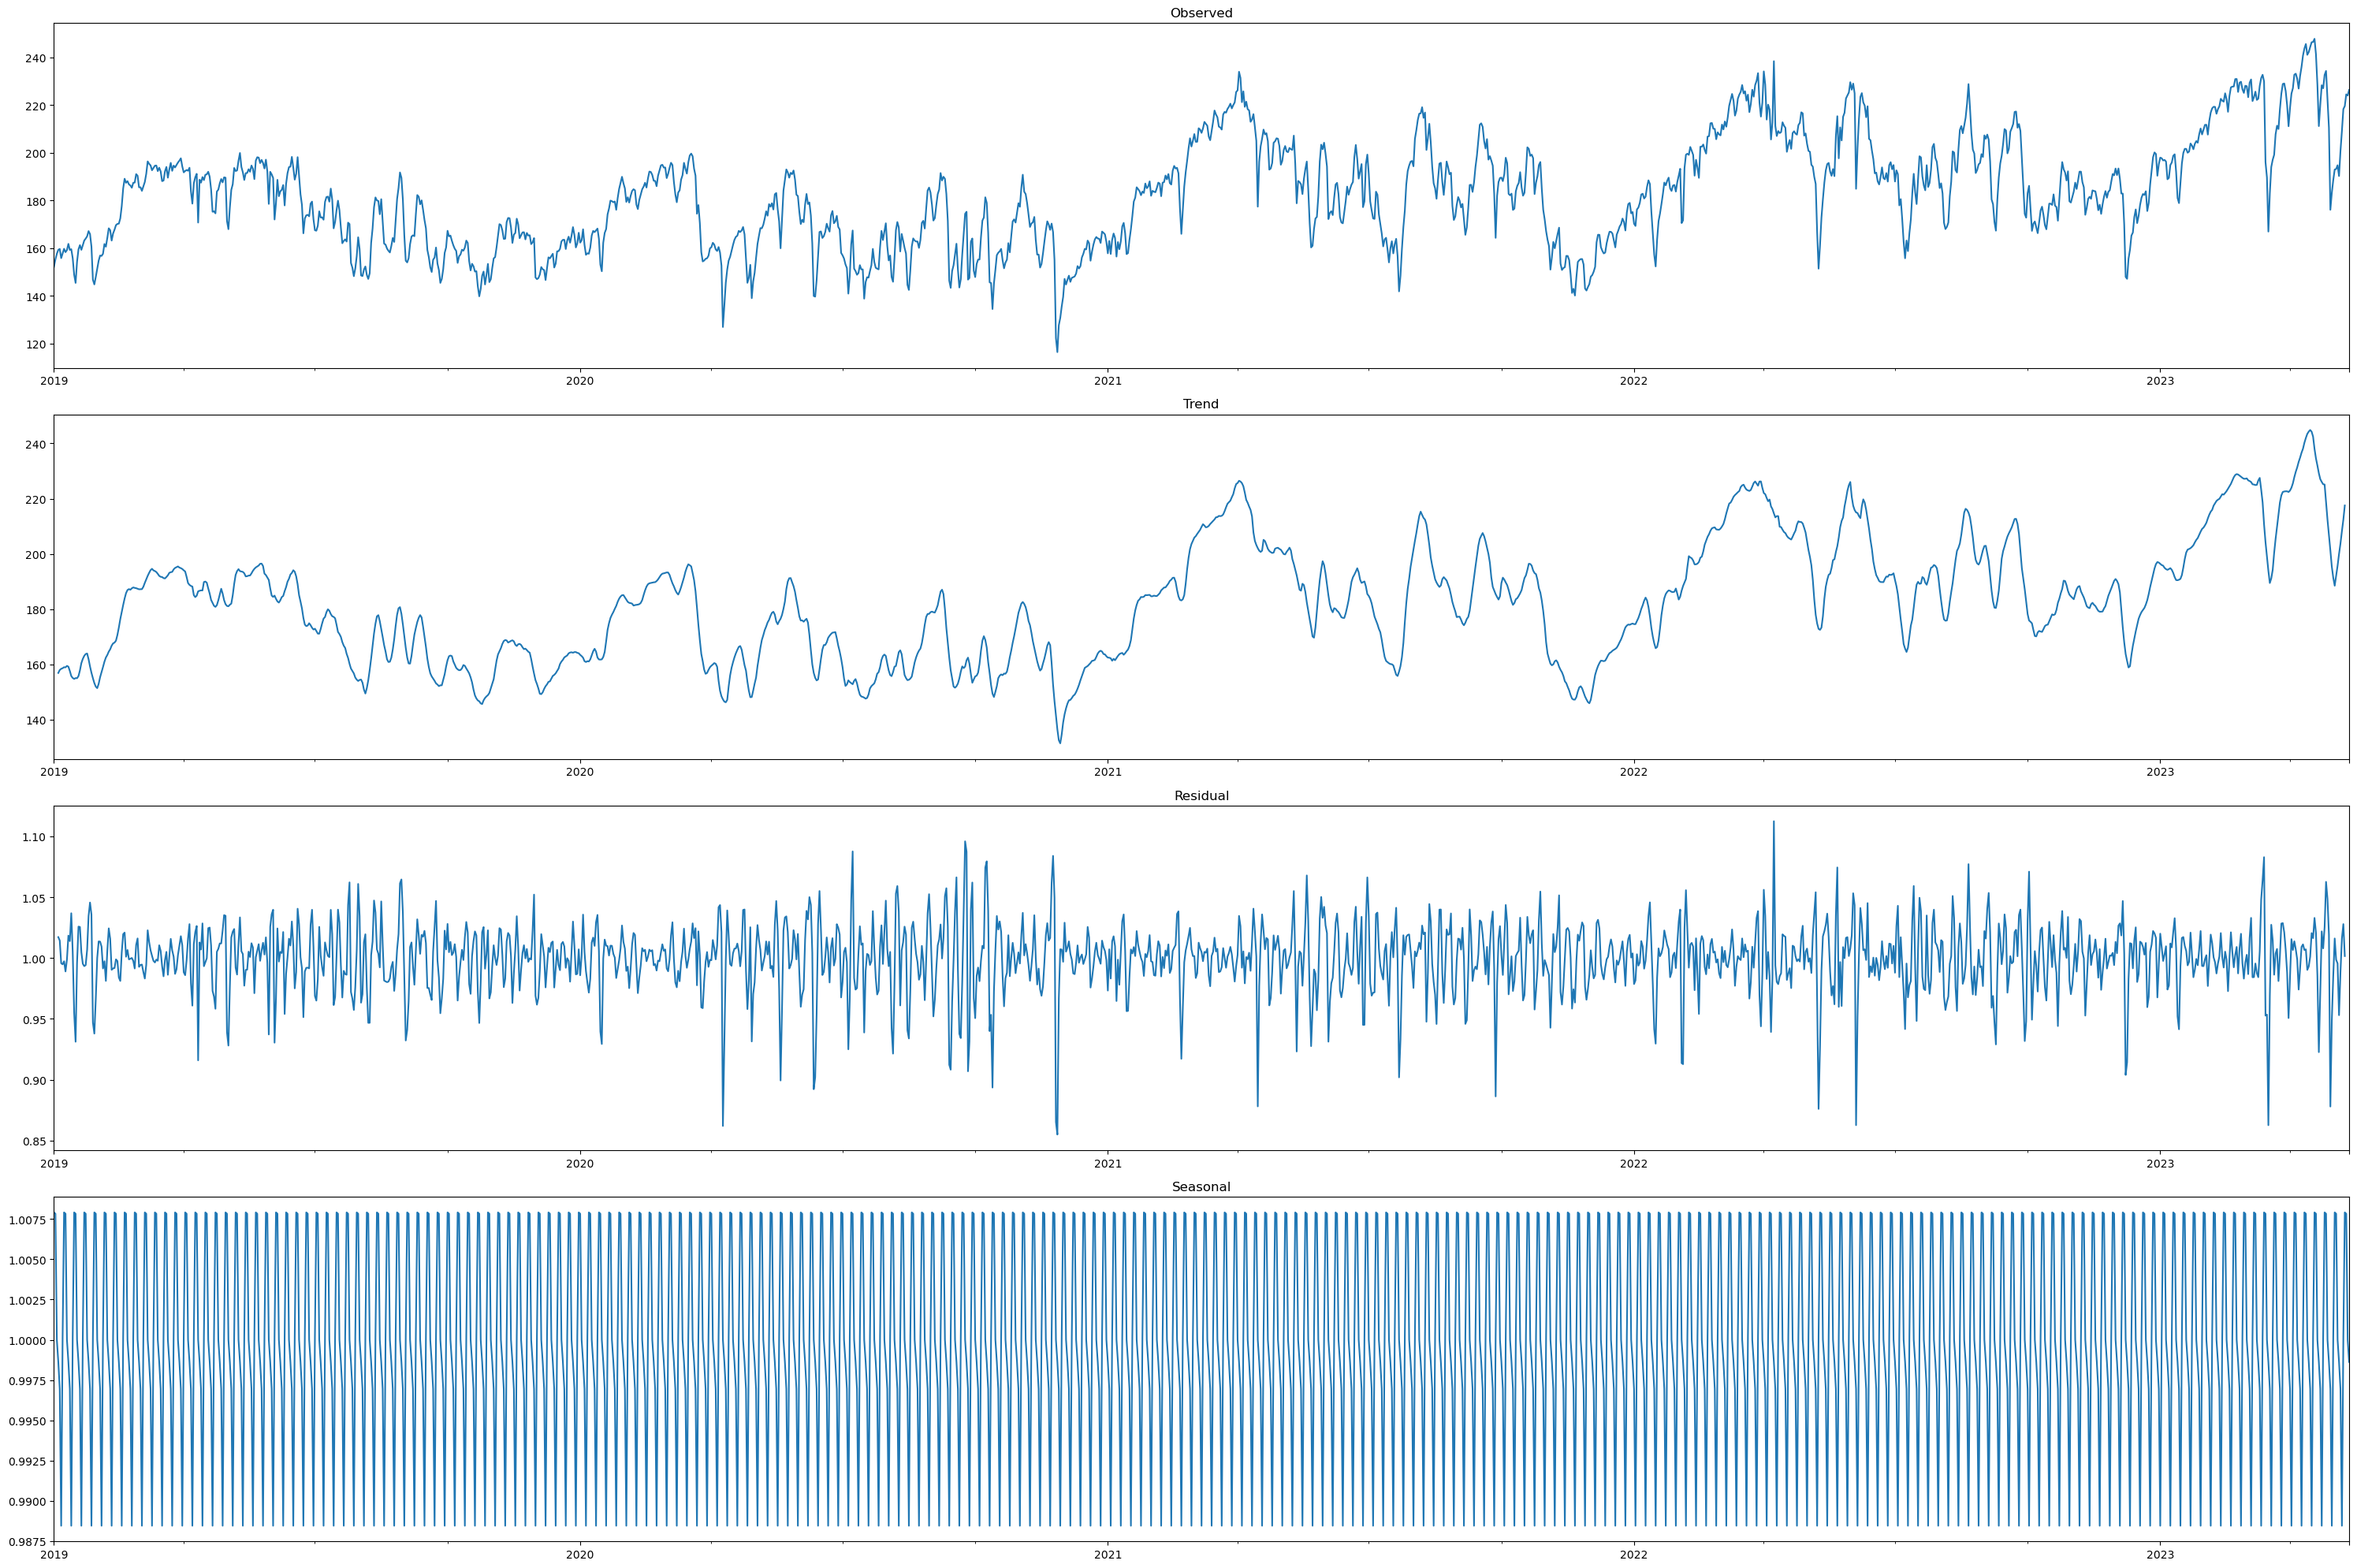

In [468]:
# Perform seasonal decomposition
res = sm.tsa.seasonal_decompose(merged_df['Energy Required (MU)'], model='multiplicative')

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(30, 20))
res.observed.plot(ax=ax1, title='Observed')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
res.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()

In [469]:
y = merged_df['Energy Required (MU)']
adf_test = adfuller(y, regression='c')
print('ADF Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(adf_test[0], adf_test[1], adf_test[2]))
for key, value in adf_test[4].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

ADF Statistic: -3.636128
p-value: 0.005107
#Lags used: 16
Critical Value (1%): -3.434506
Critical Value (5%): -2.863376
Critical Value (10%): -2.567747


The **ADF statistic** (-3.951004) is less than the critical value at 5% (-2.863416) and thus, we can say that **we reject the null hypothesis $H_{0}$ with a significance level 1%**, meaning that there is not a root-unit in the time series and thus, that it is **either stationary or could be made stationary** with 1st order differencing (difference-stationary).

In [470]:
from statsmodels.tsa.stattools import kpss

kpss_test = kpss(y, regression='c')
print('KPSS Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(kpss_test[0], kpss_test[1], kpss_test[2]))
for key, value in kpss_test[3].items():
    print(f'Critical value ({key}): {value}')


KPSS Statistic: 2.183788
p-value: 0.010000
#Lags used: 25
Critical value (10%): 0.347
Critical value (5%): 0.463
Critical value (2.5%): 0.574
Critical value (1%): 0.739


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


The **KPSS statistic (1.972154)** is higher than the critical value at 5% (0.739) and thus, we can say that **we cannot reject the null hypothesis $H_{0}$ with a significance level 5%**, meaning that the **time series is stationary **or stationary around a constant.

/opt/conda/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


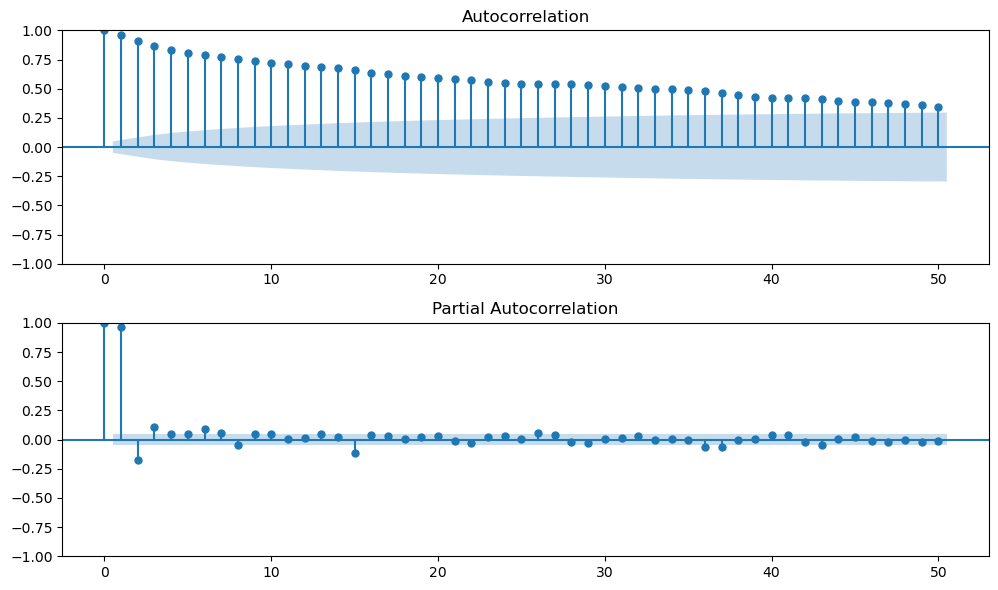

In [471]:
# Plot autocorrelation and partial autocorrelation plots

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(merged_df['Energy Required (MU)'], lags=50, ax=ax1)
plot_pacf(merged_df['Energy Required (MU)'], lags=50, ax=ax2)
plt.tight_layout()
plt.show()

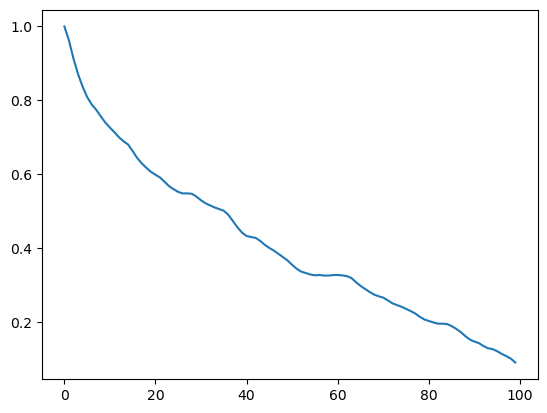

In [472]:
#plotting cross correlation plots for energy demand column
cross_corr = ccf(merged_df['Energy Required (MU)'], merged_df['Energy Required (MU)'])
plt.plot(cross_corr[0:100])
plt.show()

In [473]:
# calculating the pearson correlation coefficients
correlations = merged_df.corr(method='pearson')
print(correlations['Energy Required (MU)'].sort_values(ascending=False).to_string())

Energy Required (MU)    1.000000
Tmax                    0.523799
Tmin                    0.151125
Day                    -0.029001
Rain                   -0.378329


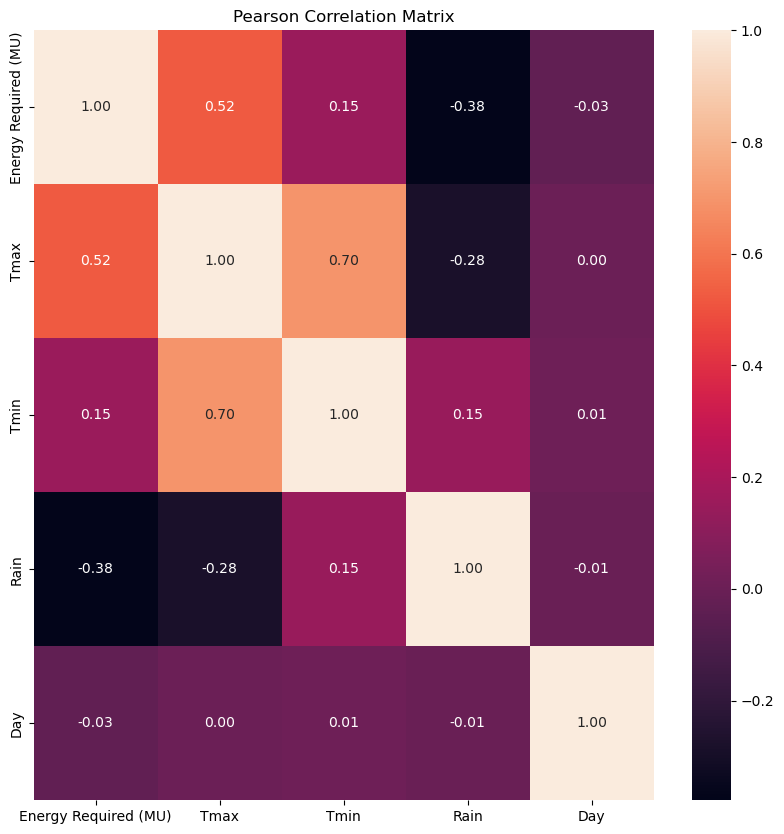

In [474]:
# plotting the correlation heatmap
correlations = merged_df.corr(method='pearson')
fig = plt.figure(figsize=(10, 10))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

In [475]:
#printing highly correlated features 
highly_correlated = abs(correlations[correlations > 0.75])
print(highly_correlated[highly_correlated < 1.0].stack().to_string())

Series([], )


In [480]:
#defining X and y for the model input
X = merged_df.values
y = merged_df['Energy Required (MU)'].values
y = y.reshape(-1, 1)


In [481]:
#shape of x
X.shape

(1593, 5)

In [482]:
#defining the end indices of train validation and test set
train_end_idx = 1200
cv_end_idx = 1410
test_end_idx = 1592

In [483]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

In [484]:
scaler_X.fit(X[:train_end_idx])
scaler_y.fit(y[:train_end_idx])

MinMaxScaler()

In [485]:
X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)

In [486]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []
    if start_index==0:
        start_index = start_index + history_size
    else:
        start_index=start_index
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

In [487]:
dataset_norm = np.concatenate((X_norm, y_norm), axis=1)
n_features = 5
past_history = 14
future_target = 1

In [488]:
X_train, y_train = multivariate_data(dataset_norm[:,0:-1], dataset_norm[:, -1],
                                     0, train_end_idx, past_history, 
                                     future_target, step=1, single_step=True)

In [489]:
X_train.shape

(1186, 14, 5)

In [490]:
X_val, y_val = multivariate_data(dataset_norm[:,0:-1], dataset_norm[:, 0],
                                 train_end_idx, cv_end_idx, past_history, 
                                 future_target, step=1, single_step=True)

In [491]:
X_val.shape

(210, 14, 5)

In [492]:
X_test, y_test = multivariate_data(dataset_norm[:,0:-1], dataset_norm[:, 0],
                                   cv_end_idx, test_end_idx, past_history, 
                                   future_target, step=1, single_step=True)

In [493]:
X_test.shape

(182, 14, 5)

In [497]:
batch_size = 32
buffer_size = 1184

In [498]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation = validation.batch(batch_size).prefetch(1)

In [499]:
# Define some common parameters

input_shape = X_train.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

In [502]:
def plot_model_rmse_and_loss(history):
    
    # Evaluate train and validation accuracies and losses
    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Visualize epochs vs. train and validation accuracies and losses
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')
    
    plt.show()

# **Vanila LSTM**

In [503]:
#Defining the model
tf.keras.backend.clear_session()

multivariate_lstm = tf.keras.models.Sequential([
    LSTM(100, input_shape=input_shape, 
         return_sequences=True),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

#defining the model checkpoint
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_lstm.h5', monitor=('val_loss'), save_best_only=True)
#defining the optimizer
optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)

multivariate_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [343]:
history = multivariate_lstm.fit(train, epochs=120,
                                validation_data=validation,
                                callbacks=[early_stopping, 
                                           model_checkpoint])

Epoch 1/120
38/38 [==============================] - 4s 34ms/step - loss: 0.0294 - root_mean_squared_error: 0.1714 - val_loss: 0.0194 - val_root_mean_squared_error: 0.1393
Epoch 2/120
38/38 [==============================] - 1s 19ms/step - loss: 0.0096 - root_mean_squared_error: 0.0978 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1197
Epoch 3/120
38/38 [==============================] - 1s 19ms/step - loss: 0.0097 - root_mean_squared_error: 0.0983 - val_loss: 0.0154 - val_root_mean_squared_error: 0.1239
Epoch 4/120
38/38 [==============================] - 1s 19ms/step - loss: 0.0083 - root_mean_squared_error: 0.0911 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1098
Epoch 5/120
38/38 [==============================] - 1s 19ms/step - loss: 0.0079 - root_mean_squared_error: 0.0890 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1098
Epoch 6/120
38/38 [==============================] - 1s 23ms/step - loss: 0.0075 - root_mean_squared_error: 0.0864 - val_loss: 0.0135 - val_

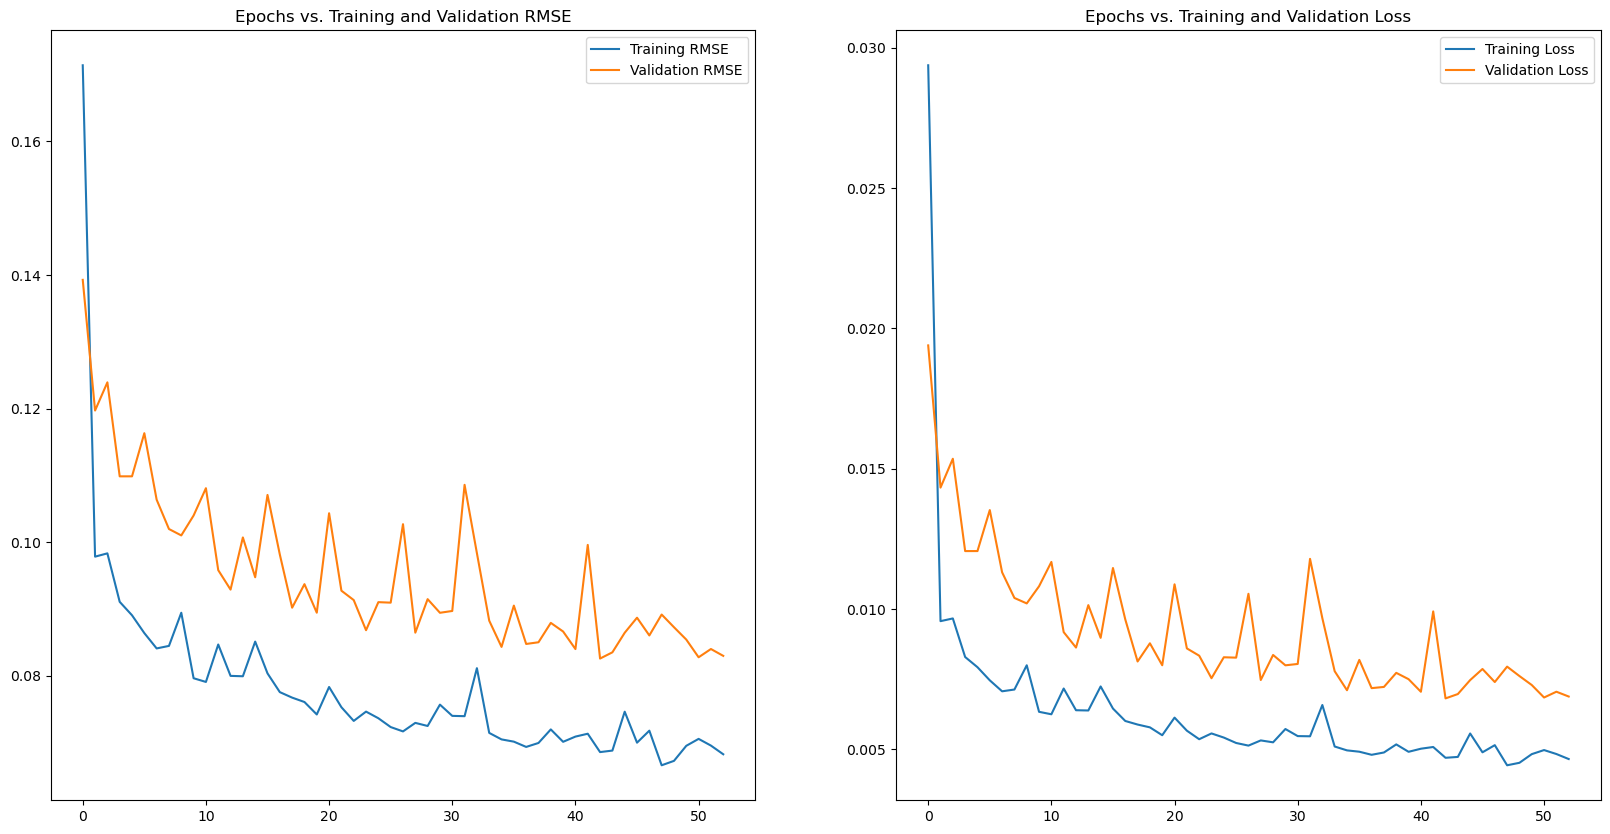

In [344]:
plot_model_rmse_and_loss(history)

In [504]:
# loading the best saved model
multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.h5')

# preparing the y_test outputs
y_test = y_test.reshape(-1, 1)
#rescaling the y_test
y_test_inv = scaler_y.inverse_transform(y_test)
#predicting on the X_text
test_forecast = multivariate_lstm.predict(X_test)
lstm_forecast = scaler_y.inverse_transform(test_forecast)
#rmse on test set
rmse_lstm = sqrt(mean_squared_error(y_test_inv,
                                    lstm_forecast))
print('RMSE of day ahead power demand LSTM forecast: {}'
      .format(round(rmse_lstm, 3)))

6/6 [==============================] - 1s 7ms/step
RMSE of day ahead power demand LSTM forecast: 9.074


In [400]:
# predicting the training output and rescaling
train_forecast = multivariate_lstm.predict(X_train)
train_forecast_inverse = scaler_y.inverse_transform(train_forecast)

#predicting the validation output and rescaling
valid_forecast = multivariate_lstm.predict(X_val)
valid_forecast_inverse = scaler_y.inverse_transform(valid_forecast)
start_idx = X_train.shape[0]+X_val.shape[0]+X_test.shape[0]+1
end_idx = start_idx+ past_history
#preparing the test set for future day ahead forecast
X_test2 = scaler_X.transform(X[start_idx:end_idx,:])
X_test2 = X_test2.reshape(1,past_history,n_features)
#prediction using the trained model
forecast_unseen = multivariate_lstm.predict(X_test2)
forecast_unseen_inverse = scaler_y.inverse_transform(forecast_unseen)
print("Unseen data forecast :",forecast_unseen_inverse)

1/1 [==============================] - 0s 28ms/step
Unseen data forecast : [[232.99066]]


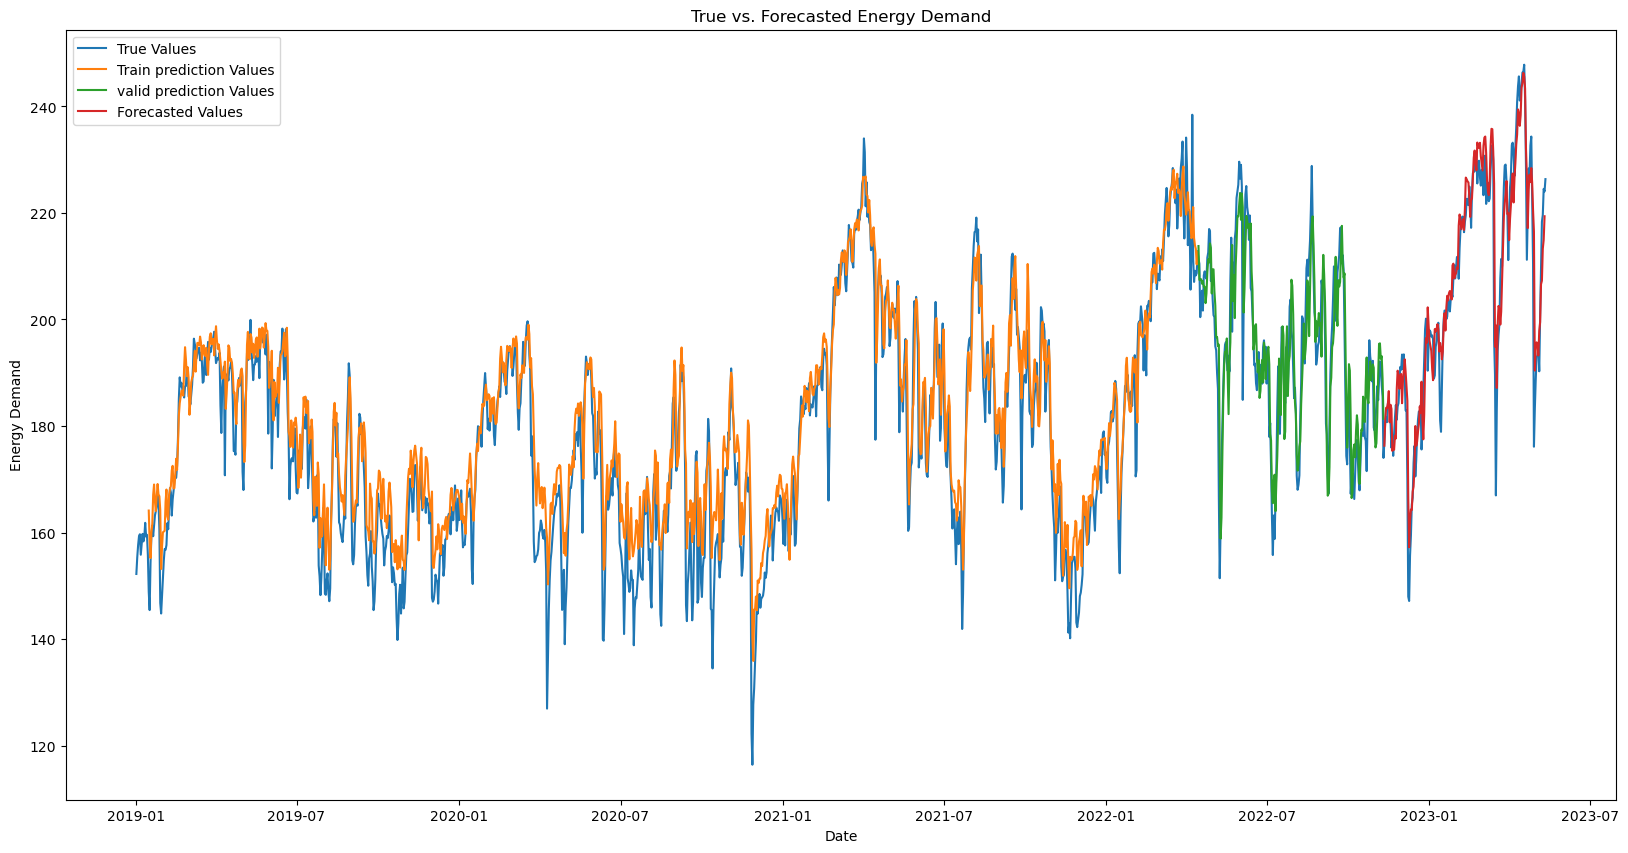

In [505]:
import matplotlib.pyplot as plt

# Assuming merged_df is your DataFrame with the date column set as the index
true_values = merged_df['Energy Required (MU)'].values

# Create arrays for the x-axis (dates)
dates_true = merged_df.index[:len(merged_df)]
dates_train_pred = merged_df.index[past_history:train_end_idx]
dates_valid_pred = merged_df.index[train_end_idx:cv_end_idx]
dates_forecasted = merged_df.index[cv_end_idx:test_end_idx]
dates_unseen = merged_df.index[start_idx:end_idx]


# Plotting the true values and forecasted values
plt.figure(figsize=(20, 10))
plt.plot(dates_true, true_values[:len(merged_df)], label='True Values')
plt.plot(dates_train_pred, train_forecast_inverse, label='Train prediction Values')
plt.plot(dates_valid_pred, valid_forecast_inverse, label='valid prediction Values')
plt.plot(dates_forecasted, lstm_forecast, label='Forecasted Values')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('True vs. Forecasted Energy Demand')
plt.legend()

'''# Adding another plot for unseen predictions
plt.figure(figsize=(12, 6))
plt.plot(dates_unseen, forecasted_values[161:], label='Unseen Predictions')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('Unseen Predictions')
plt.legend()'''

plt.show()


# **Stacked LSTM**

In [405]:
tf.keras.backend.clear_session()

from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten, LeakyReLU

multivariate_stacked_lstm = tf.keras.models.Sequential([
    LSTM(250, input_shape=input_shape, return_sequences=True),
    LSTM(200, return_sequences=True),
    LSTM(150, return_sequences=True),
    LSTM(100, return_sequences=True),
    LSTM(50),
    Flatten(),
    Dense(150),
    LeakyReLU(),
    Dropout(0.2),
    Dense(1)
])


model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_stacked_lstm.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=3e-3, amsgrad=True)

multivariate_stacked_lstm.compile(loss=loss,
                                  optimizer=optimizer,
                                  metrics=metric)

In [406]:
history = multivariate_stacked_lstm.fit(train, epochs=120,
                                validation_data=validation,
                                callbacks=[early_stopping, 
                                           model_checkpoint])

Epoch 1/120
38/38 [==============================] - 18s 181ms/step - loss: 0.0492 - root_mean_squared_error: 0.2071 - val_loss: 0.0203 - val_root_mean_squared_error: 0.1426
Epoch 2/120
38/38 [==============================] - 5s 133ms/step - loss: 0.0180 - root_mean_squared_error: 0.1342 - val_loss: 0.0267 - val_root_mean_squared_error: 0.1634
Epoch 3/120
38/38 [==============================] - 4s 116ms/step - loss: 0.0141 - root_mean_squared_error: 0.1189 - val_loss: 0.0218 - val_root_mean_squared_error: 0.1475
Epoch 4/120
38/38 [==============================] - 5s 137ms/step - loss: 0.0134 - root_mean_squared_error: 0.1156 - val_loss: 0.0217 - val_root_mean_squared_error: 0.1472
Epoch 5/120
38/38 [==============================] - 5s 125ms/step - loss: 0.0133 - root_mean_squared_error: 0.1153 - val_loss: 0.0269 - val_root_mean_squared_error: 0.1641
Epoch 6/120
38/38 [==============================] - 4s 118ms/step - loss: 0.0167 - root_mean_squared_error: 0.1292 - val_loss: 0.0281

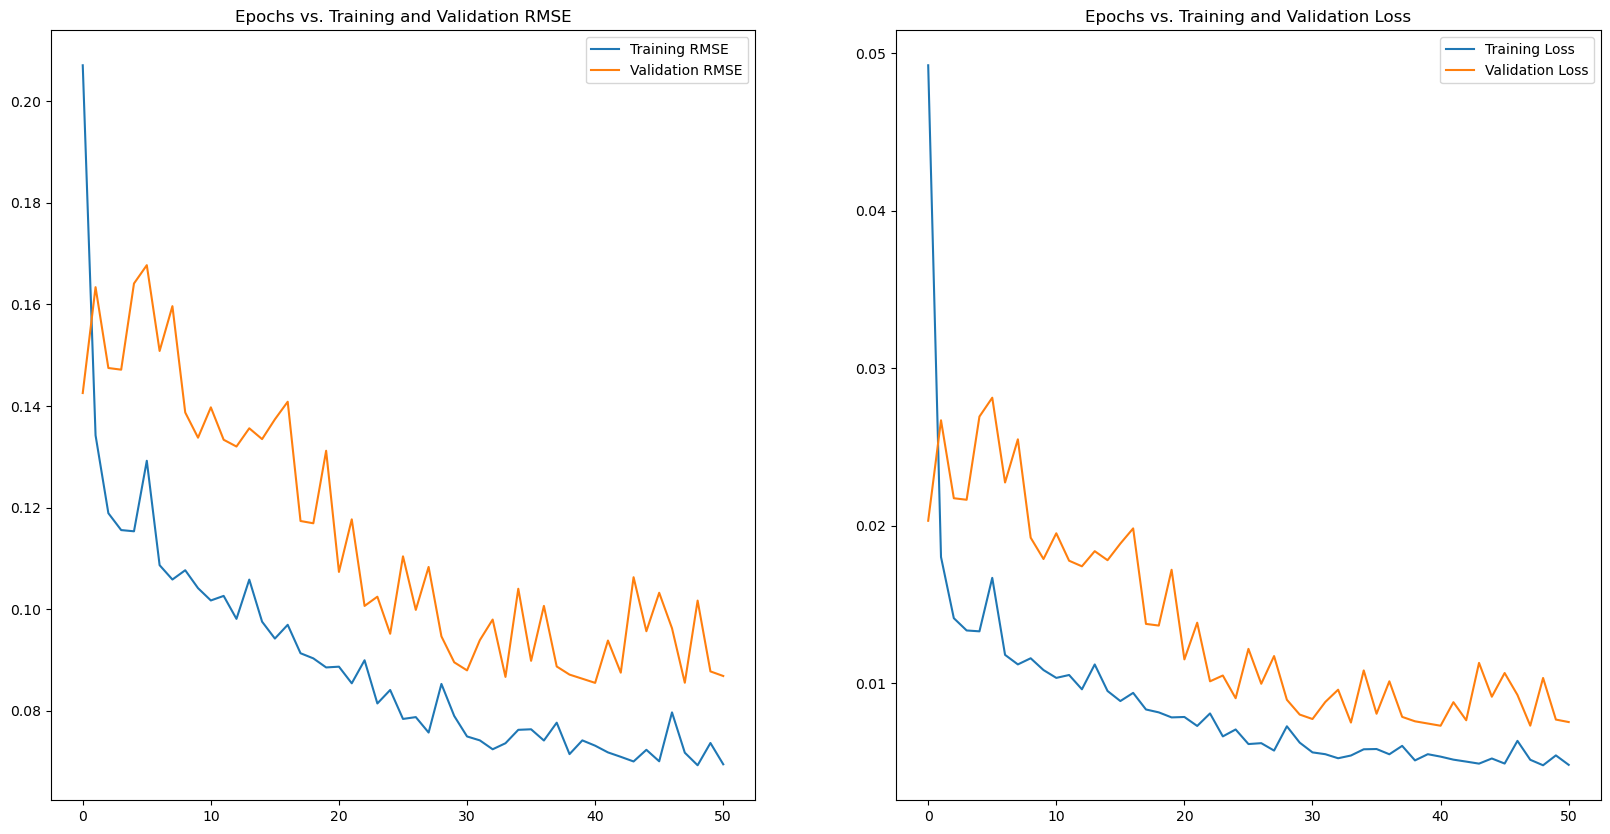

In [408]:
plot_model_rmse_and_loss(history)

In [409]:
multivariate_stacked_lstm = tf.keras.models.load_model('multivariate_stacked_lstm.h5')

forecast = multivariate_stacked_lstm.predict(X_test)
multivariate_stacked_lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_stacked_lstm = sqrt(mean_squared_error(y_test_inv, 
                                                 multivariate_stacked_lstm_forecast))
print('RMSE of day ahead power demand multivariate Stacked LSTM forecast: {}'
      .format(round(rmse_mult_stacked_lstm, 3)))


6/6 [==============================] - 2s 39ms/step
RMSE of day ahead power demand multivariate Stacked LSTM forecast: 9.944


In [414]:
multivariate_stacked_lstm = tf.keras.models.load_model('multivariate_stacked_lstm.h5')

forecast_unseen = multivariate_stacked_lstm.predict(X_test2)
lstm_forecast_unseen = scaler_y.inverse_transform(forecast_unseen)
print(lstm_forecast_unseen)

1/1 [==============================] - 2s 2s/step
[[230.00888]]


1/1 [==============================] - 0s 31ms/step
Unseen data forecast : [[230.00888]]


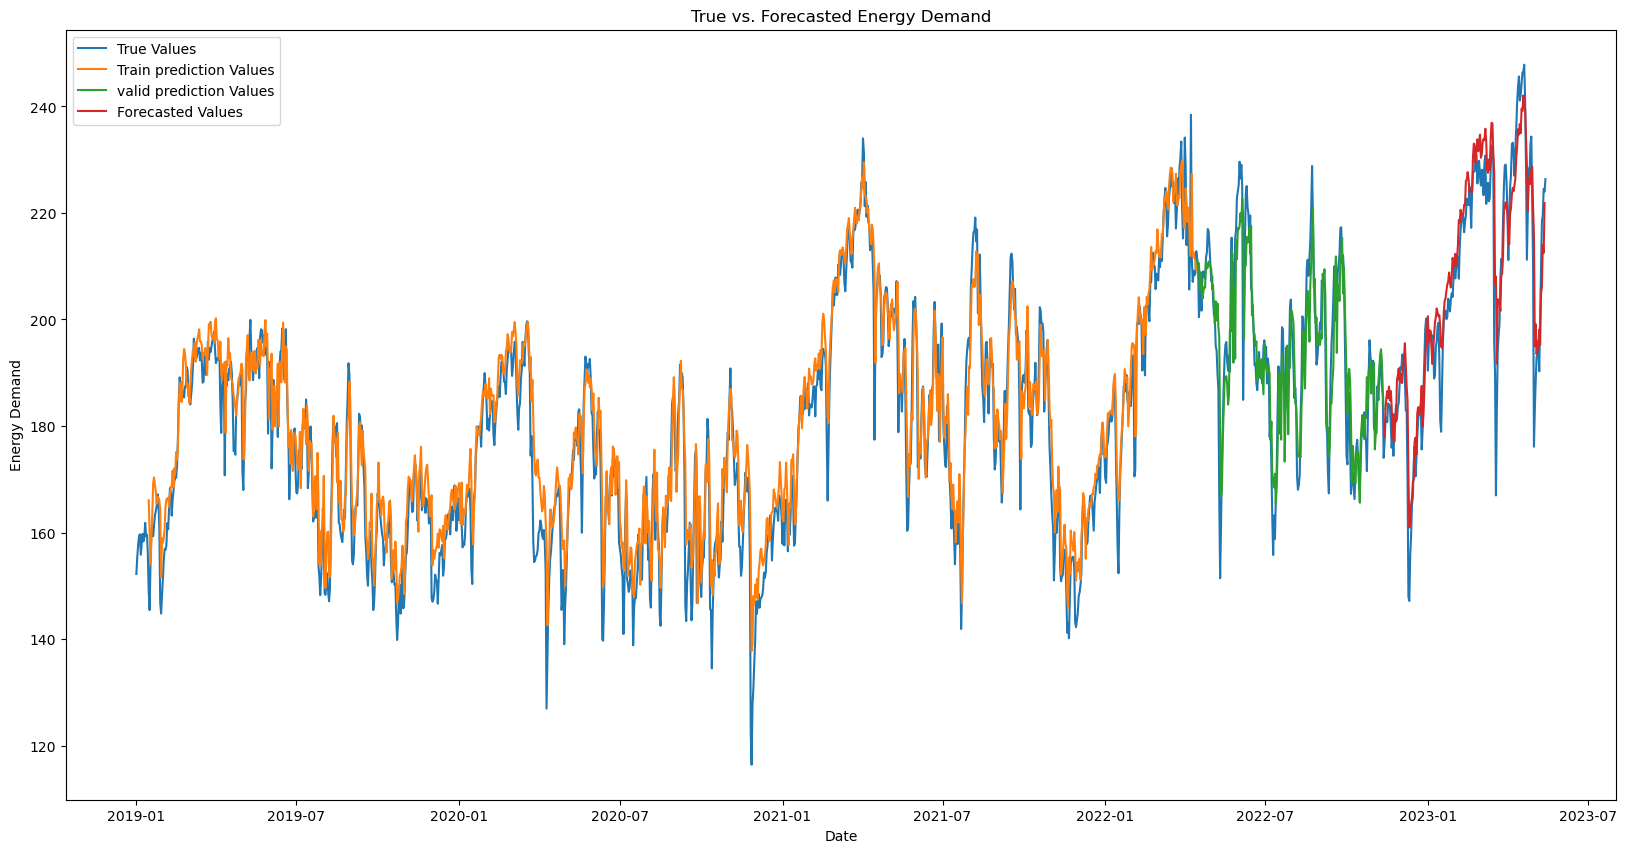

In [415]:
# predicting the training output and rescaling
train_forecast = multivariate_stacked_lstm.predict(X_train)
train_forecast_inverse = scaler_y.inverse_transform(train_forecast)

#predicting the validation output and rescaling
valid_forecast = multivariate_stacked_lstm.predict(X_val)
valid_forecast_inverse = scaler_y.inverse_transform(valid_forecast)

start_idx = X_train.shape[0]+X_val.shape[0]+X_test.shape[0]+1
end_idx = start_idx+ past_history
#preparing the test set for future day ahead forecast
X_test2 = scaler_X.transform(X[start_idx:end_idx,:])
X_test2 = X_test2.reshape(1,past_history,n_features)
#prediction using the trained model
forecast_unseen = multivariate_stacked_lstm.predict(X_test2)
forecast_unseen_inverse = scaler_y.inverse_transform(forecast_unseen)
print("Unseen data forecast :",forecast_unseen_inverse)


# Assuming merged_df is your DataFrame with the date column set as the index
true_values = merged_df['Energy Required (MU)'].values

# Create arrays for the x-axis (dates)
dates_true = merged_df.index[:len(merged_df)]
dates_train_pred = merged_df.index[past_history:train_end_idx]
dates_valid_pred = merged_df.index[train_end_idx:cv_end_idx]
dates_forecasted = merged_df.index[cv_end_idx:test_end_idx]
dates_unseen = merged_df.index[start_idx:end_idx]


# Plotting the true values and forecasted values
plt.figure(figsize=(20, 10))
plt.plot(dates_true, true_values[:len(merged_df)], label='True Values')
plt.plot(dates_train_pred, train_forecast_inverse, label='Train prediction Values')
plt.plot(dates_valid_pred, valid_forecast_inverse, label='valid prediction Values')
plt.plot(dates_forecasted, multivariate_stacked_lstm_forecast, label='Forecasted Values')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('True vs. Forecasted Energy Demand')
plt.legend()

'''# Adding another plot for unseen predictions
plt.figure(figsize=(12, 6))
plt.plot(dates_unseen, forecasted_values[161:], label='Unseen Predictions')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('Unseen Predictions')
plt.legend()'''

plt.show()


# **CNN**

In [416]:
tf.keras.backend.clear_session()

multivariate_cnn = tf.keras.models.Sequential([
    Conv1D(filters=48, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    Flatten(),
    Dense(48, activation='relu'),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)

multivariate_cnn.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [417]:
history = multivariate_cnn.fit(train, epochs=120,
                               validation_data=validation,
                               callbacks=[early_stopping, 
                                          model_checkpoint])

Epoch 1/120
38/38 [==============================] - 1s 8ms/step - loss: 0.0177 - root_mean_squared_error: 0.1270 - val_loss: 0.0162 - val_root_mean_squared_error: 0.1272
Epoch 2/120
38/38 [==============================] - 0s 3ms/step - loss: 0.0087 - root_mean_squared_error: 0.0933 - val_loss: 0.0185 - val_root_mean_squared_error: 0.1361
Epoch 3/120
38/38 [==============================] - 0s 4ms/step - loss: 0.0076 - root_mean_squared_error: 0.0869 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1091
Epoch 4/120
38/38 [==============================] - 0s 4ms/step - loss: 0.0069 - root_mean_squared_error: 0.0831 - val_loss: 0.0149 - val_root_mean_squared_error: 0.1221
Epoch 5/120
38/38 [==============================] - 0s 4ms/step - loss: 0.0059 - root_mean_squared_error: 0.0768 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1030
Epoch 6/120
38/38 [==============================] - 0s 4ms/step - loss: 0.0060 - root_mean_squared_error: 0.0774 - val_loss: 0.0101 - val_root_m

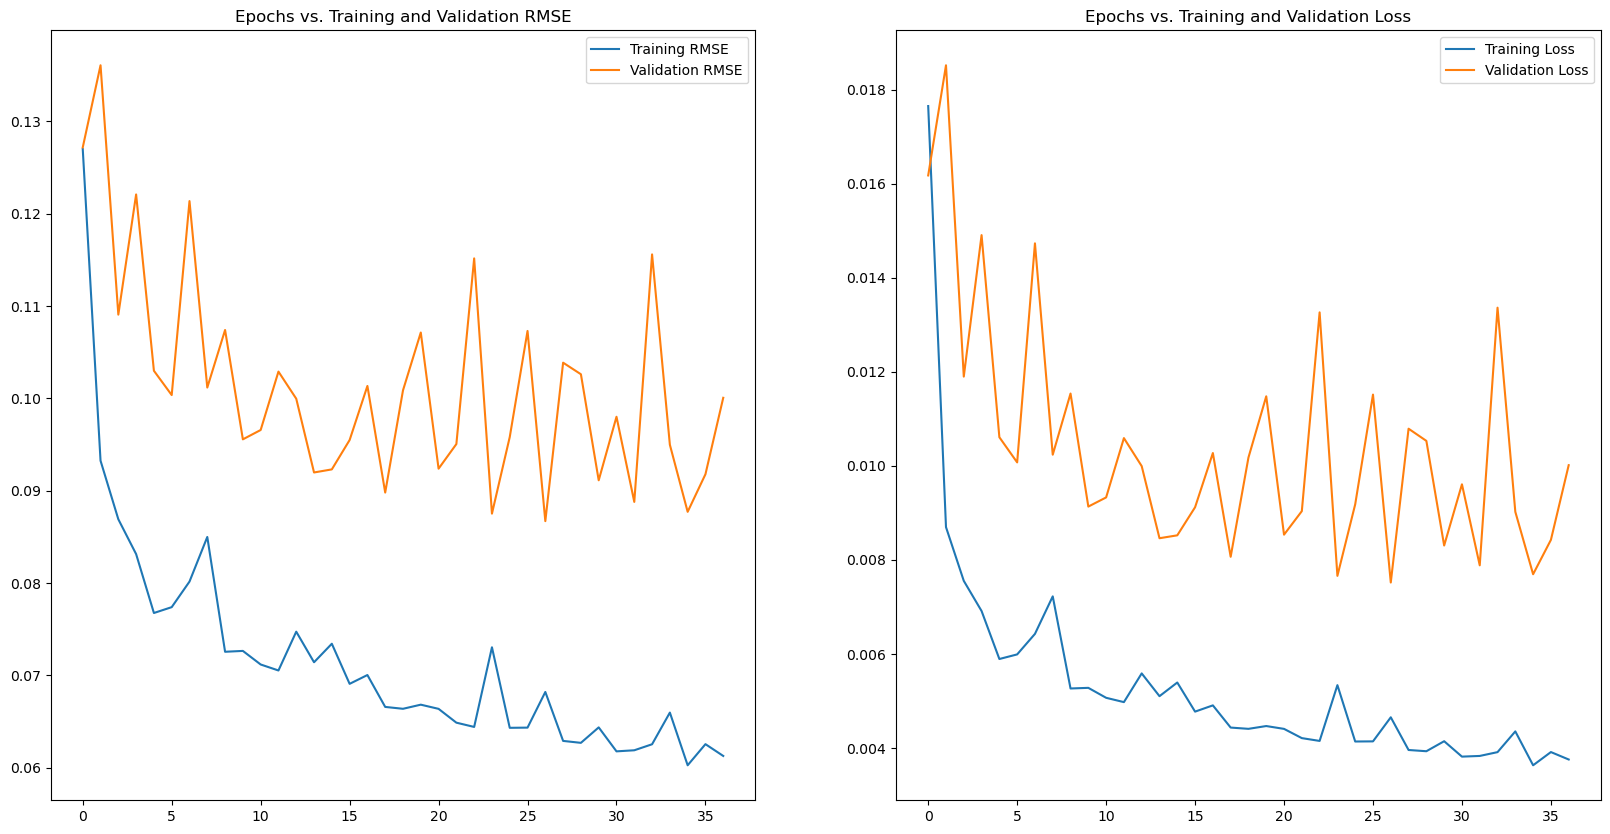

In [418]:
plot_model_rmse_and_loss(history)

In [419]:
multivariate_cnn = tf.keras.models.load_model('multivariate_cnn.h5')

forecast = multivariate_cnn.predict(X_test)
multivariate_cnn_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_cnn = sqrt(mean_squared_error(y_test_inv,
                                        multivariate_cnn_forecast))
print('RMSE of day ahead electricity price multivariate CNN forecast: {}'
      .format(round(rmse_mult_cnn, 3)))

6/6 [==============================] - 0s 2ms/step
RMSE of day ahead electricity price multivariate CNN forecast: 10.092


1/1 [==============================] - 0s 25ms/step
Unseen data forecast : [[228.4865]]


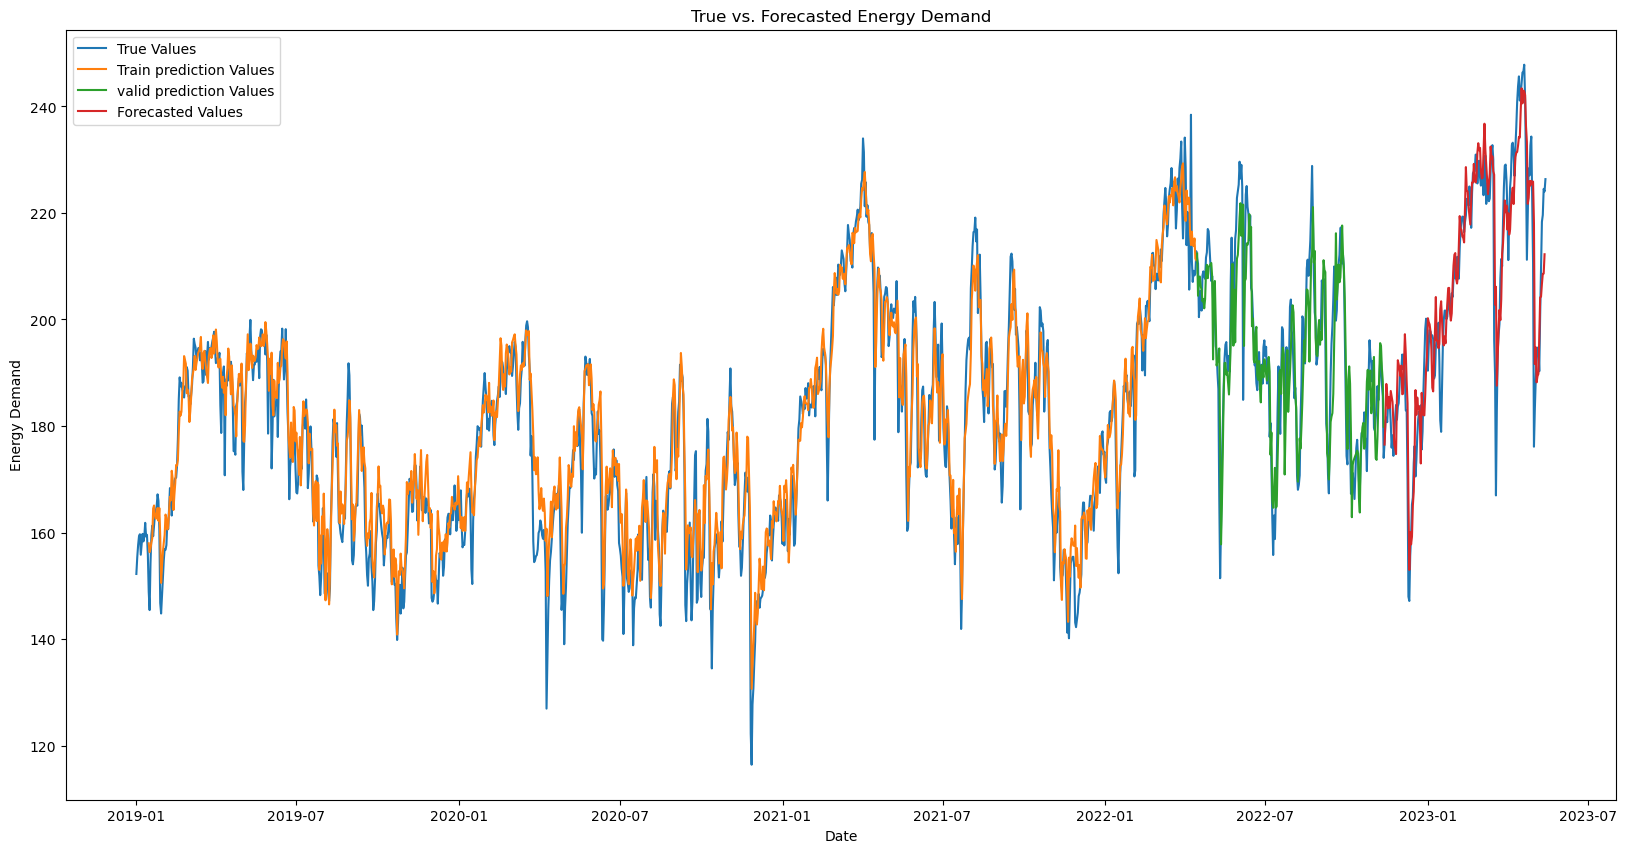

In [422]:
# predicting the training output and rescaling
train_forecast = multivariate_cnn.predict(X_train)
train_forecast_inverse = scaler_y.inverse_transform(train_forecast)

#predicting the validation output and rescaling
valid_forecast = multivariate_cnn.predict(X_val)
valid_forecast_inverse = scaler_y.inverse_transform(valid_forecast)

start_idx = X_train.shape[0]+X_val.shape[0]+X_test.shape[0]+1
end_idx = start_idx+ past_history
#preparing the test set for future day ahead forecast
X_test2 = scaler_X.transform(X[start_idx:end_idx,:])
X_test2 = X_test2.reshape(1,past_history,n_features)
#prediction using the trained model
forecast_unseen = multivariate_cnn.predict(X_test2)
forecast_unseen_inverse = scaler_y.inverse_transform(forecast_unseen)
print("Unseen data forecast :",forecast_unseen_inverse)


# Assuming merged_df is your DataFrame with the date column set as the index
true_values = merged_df['Energy Required (MU)'].values

# Create arrays for the x-axis (dates)
dates_true = merged_df.index[:len(merged_df)]
dates_train_pred = merged_df.index[past_history:train_end_idx]
dates_valid_pred = merged_df.index[train_end_idx:cv_end_idx]
dates_forecasted = merged_df.index[cv_end_idx:test_end_idx]
dates_unseen = merged_df.index[start_idx:end_idx]


# Plotting the true values and forecasted values
plt.figure(figsize=(20, 10))
plt.plot(dates_true, true_values[:len(merged_df)], label='True Values')
plt.plot(dates_train_pred, train_forecast_inverse, label='Train prediction Values')
plt.plot(dates_valid_pred, valid_forecast_inverse, label='valid prediction Values')
plt.plot(dates_forecasted, multivariate_cnn_forecast, label='Forecasted Values')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('True vs. Forecasted Energy Demand')
plt.legend()

'''# Adding another plot for unseen predictions
plt.figure(figsize=(12, 6))
plt.plot(dates_unseen, forecasted_values[161:], label='Unseen Predictions')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('Unseen Predictions')
plt.legend()'''

plt.show()


# **CNN- LSTM**

In [423]:
tf.keras.backend.clear_session()

multivariate_cnn_lstm = tf.keras.models.Sequential([
    Conv1D(filters=100, kernel_size=2,
           strides=1, padding='causal',
           activation='relu',
           input_shape=input_shape),
    Conv1D(filters=100, kernel_size=2,
           strides=1, padding='causal',
           activation='relu'),
    Conv1D(filters=100, kernel_size=2,
           strides=1, padding='causal',
           activation='relu'),
    LSTM(150, return_sequences=True),
    LSTM(100, return_sequences=True),
    LSTM(50),
    Flatten(),
    Dense(100),
    LeakyReLU(),
    Dropout(0.2),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn_lstm.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=4e-3, amsgrad=True)

multivariate_cnn_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)


In [424]:
history = multivariate_cnn_lstm.fit(train, epochs=120,
                                    validation_data=validation,
                                    callbacks=[early_stopping, 
                                               model_checkpoint])

Epoch 1/120
38/38 [==============================] - 13s 102ms/step - loss: 0.0353 - root_mean_squared_error: 0.1774 - val_loss: 0.0279 - val_root_mean_squared_error: 0.1670
Epoch 2/120
38/38 [==============================] - 2s 59ms/step - loss: 0.0131 - root_mean_squared_error: 0.1145 - val_loss: 0.0240 - val_root_mean_squared_error: 0.1548
Epoch 3/120
38/38 [==============================] - 2s 59ms/step - loss: 0.0123 - root_mean_squared_error: 0.1109 - val_loss: 0.0287 - val_root_mean_squared_error: 0.1694
Epoch 4/120
38/38 [==============================] - 2s 52ms/step - loss: 0.0127 - root_mean_squared_error: 0.1129 - val_loss: 0.0283 - val_root_mean_squared_error: 0.1684
Epoch 5/120
38/38 [==============================] - 2s 55ms/step - loss: 0.0112 - root_mean_squared_error: 0.1056 - val_loss: 0.0181 - val_root_mean_squared_error: 0.1345
Epoch 6/120
38/38 [==============================] - 2s 52ms/step - loss: 0.0105 - root_mean_squared_error: 0.1027 - val_loss: 0.0226 - va

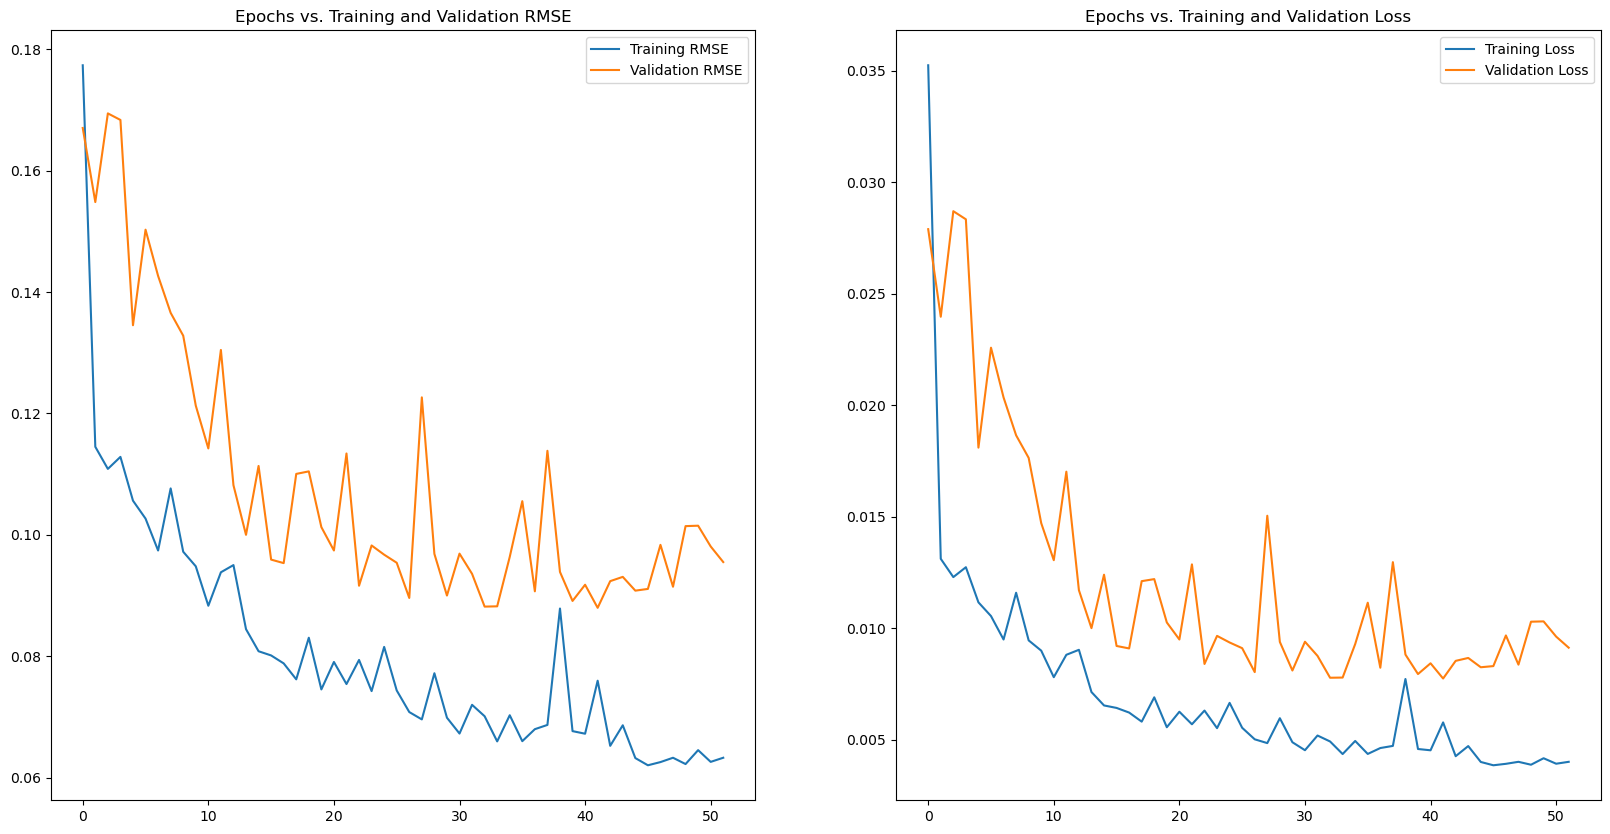

In [427]:
plot_model_rmse_and_loss(history)

In [428]:
multivariate_cnn_lstm = tf.keras.models.load_model('multivariate_cnn_lstm.h5')

forecast = multivariate_cnn_lstm.predict(X_test)
multivariate_cnn_lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_cnn_lstm = sqrt(mean_squared_error(y_test_inv, 
                                             multivariate_cnn_lstm_forecast))
print('RMSE of day-ahead power demand  multivariate CNN-`LSTM forecast: {}'
      .format(round(rmse_mult_cnn_lstm, 3)))

6/6 [==============================] - 1s 16ms/step
RMSE of day-ahead power demand  multivariate CNN-`LSTM forecast: 10.718


1/1 [==============================] - 0s 27ms/step
Unseen data forecast : [[225.60788]]


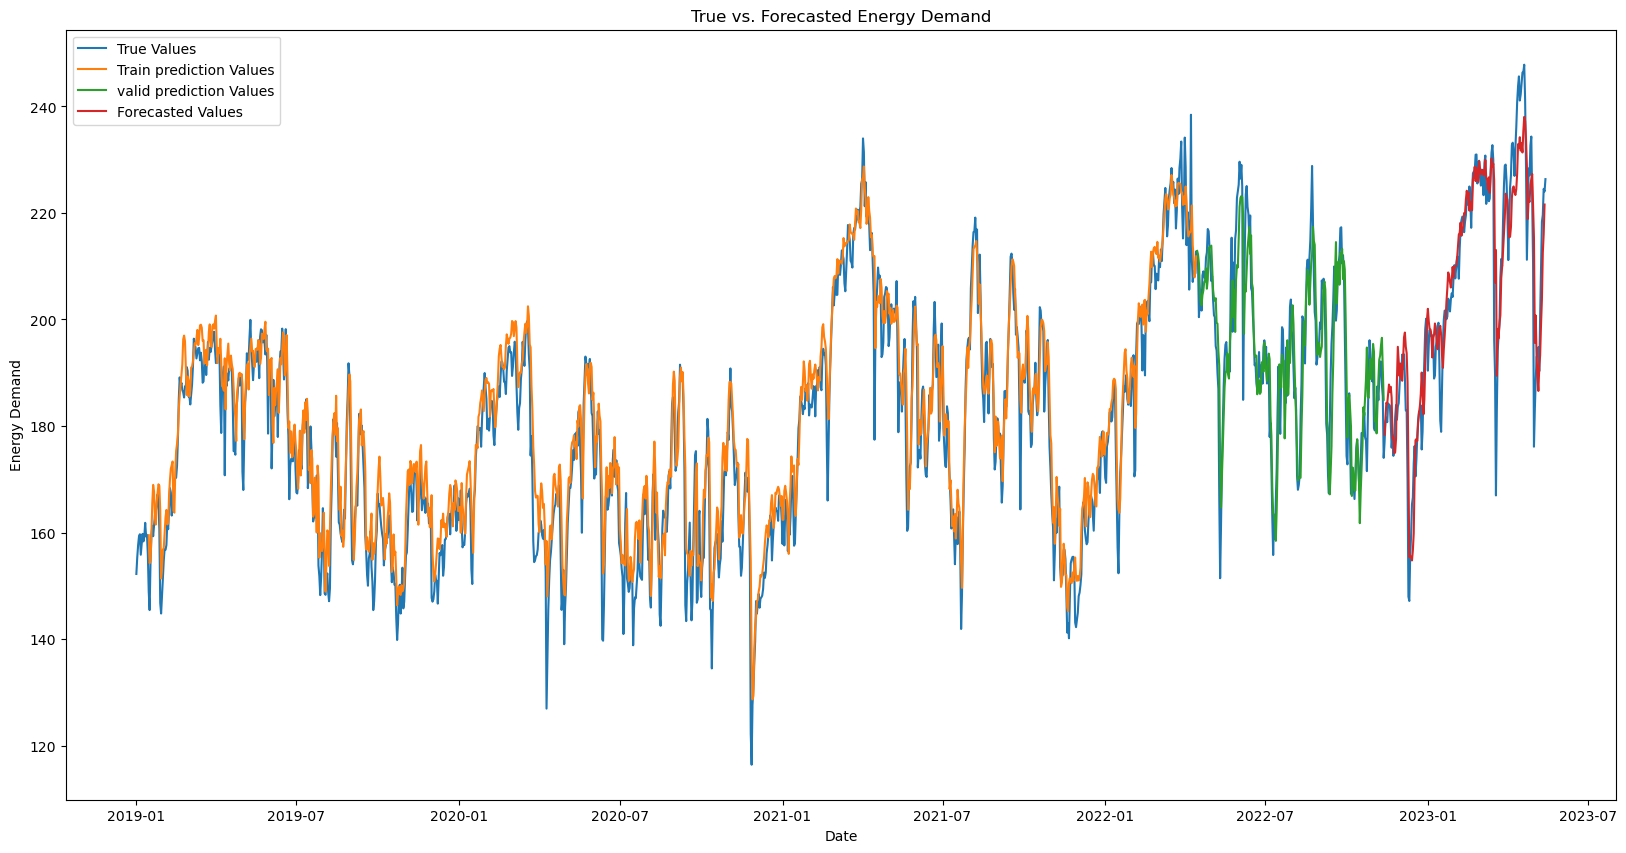

In [429]:
# predicting the training output and rescaling
train_forecast = multivariate_cnn_lstm.predict(X_train)
train_forecast_inverse = scaler_y.inverse_transform(train_forecast)

#predicting the validation output and rescaling
valid_forecast = multivariate_cnn_lstm.predict(X_val)
valid_forecast_inverse = scaler_y.inverse_transform(valid_forecast)

start_idx = X_train.shape[0]+X_val.shape[0]+X_test.shape[0]+1
end_idx = start_idx+ past_history
#preparing the test set for future day ahead forecast
X_test2 = scaler_X.transform(X[start_idx:end_idx,:])
X_test2 = X_test2.reshape(1,past_history,n_features)
#prediction using the trained model
forecast_unseen = multivariate_cnn_lstm.predict(X_test2)
forecast_unseen_inverse = scaler_y.inverse_transform(forecast_unseen)
print("Unseen data forecast :",forecast_unseen_inverse)


# Assuming merged_df is your DataFrame with the date column set as the index
true_values = merged_df['Energy Required (MU)'].values

# Create arrays for the x-axis (dates)
dates_true = merged_df.index[:len(merged_df)]
dates_train_pred = merged_df.index[past_history:train_end_idx]
dates_valid_pred = merged_df.index[train_end_idx:cv_end_idx]
dates_forecasted = merged_df.index[cv_end_idx:test_end_idx]
dates_unseen = merged_df.index[start_idx:end_idx]


# Plotting the true values and forecasted values
plt.figure(figsize=(20, 10))
plt.plot(dates_true, true_values[:len(merged_df)], label='True Values')
plt.plot(dates_train_pred, train_forecast_inverse, label='Train prediction Values')
plt.plot(dates_valid_pred, valid_forecast_inverse, label='valid prediction Values')
plt.plot(dates_forecasted, multivariate_cnn_lstm_forecast, label='Forecasted Values')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('True vs. Forecasted Energy Demand')
plt.legend()

'''# Adding another plot for unseen predictions
plt.figure(figsize=(12, 6))
plt.plot(dates_unseen, forecasted_values[161:], label='Unseen Predictions')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('Unseen Predictions')
plt.legend()'''

plt.show()


# **Time Distributed MLP**

In [430]:
tf.keras.backend.clear_session()

multivariate_mlp = tf.keras.models.Sequential([
    TimeDistributed(Dense(200, activation='relu'),
                    input_shape=input_shape),
    TimeDistributed(Dense(150, activation='relu')),
    TimeDistributed(Dense(100, activation='relu')),
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_mlp.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=2e-3, amsgrad=True)

multivariate_mlp.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [431]:
history = multivariate_mlp.fit(train, epochs=120,
                               validation_data=validation,
                               callbacks=[early_stopping, 
                                          model_checkpoint])

Epoch 1/120
38/38 [==============================] - 2s 15ms/step - loss: 0.0271 - root_mean_squared_error: 0.1562 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1161
Epoch 2/120
38/38 [==============================] - 0s 9ms/step - loss: 0.0074 - root_mean_squared_error: 0.0863 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1011
Epoch 3/120
38/38 [==============================] - 0s 8ms/step - loss: 0.0077 - root_mean_squared_error: 0.0876 - val_loss: 0.0204 - val_root_mean_squared_error: 0.1427
Epoch 4/120
38/38 [==============================] - 0s 8ms/step - loss: 0.0073 - root_mean_squared_error: 0.0854 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1040
Epoch 5/120
38/38 [==============================] - 0s 8ms/step - loss: 0.0063 - root_mean_squared_error: 0.0794 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1031
Epoch 6/120
38/38 [==============================] - 0s 9ms/step - loss: 0.0060 - root_mean_squared_error: 0.0773 - val_loss: 0.0124 - val_root_

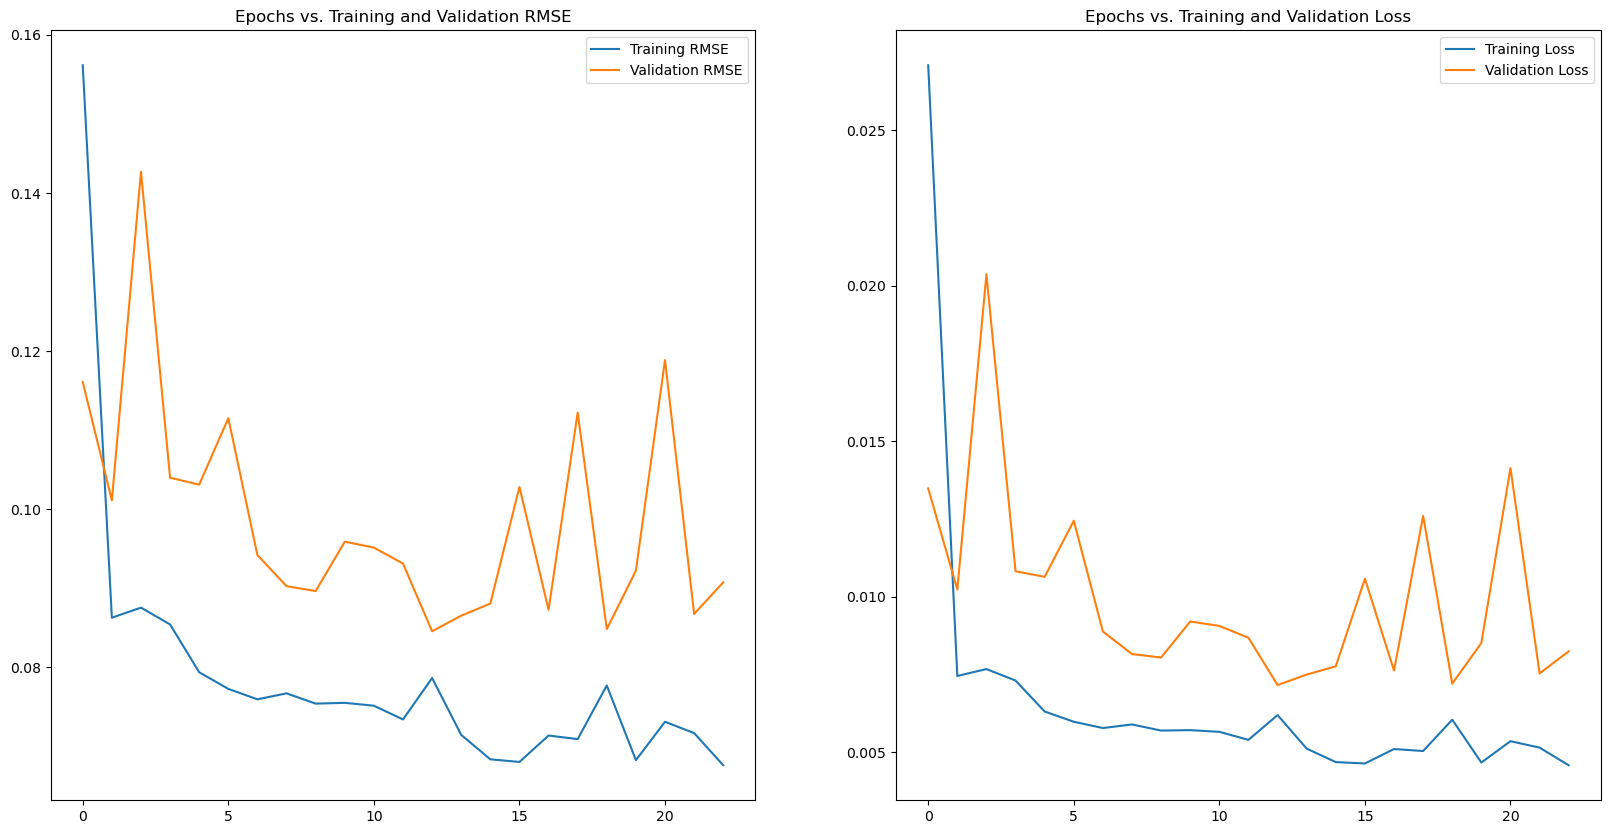

In [432]:
plot_model_rmse_and_loss(history)

In [433]:
multivariate_mlp = tf.keras.models.load_model('multivariate_mlp.h5')

forecast = multivariate_mlp.predict(X_test)
multivariate_mlp_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_mlp = sqrt(mean_squared_error(y_test_inv,
                                        multivariate_mlp_forecast))
print('RMSE of day-ahead power demand multivariate MLP forecast: {}'
      .format(round(rmse_mult_mlp, 3)))

6/6 [==============================] - 0s 3ms/step
RMSE of day-ahead power demand multivariate MLP forecast: 10.235


1/1 [==============================] - 0s 22ms/step
Unseen data forecast : [[226.55582]]


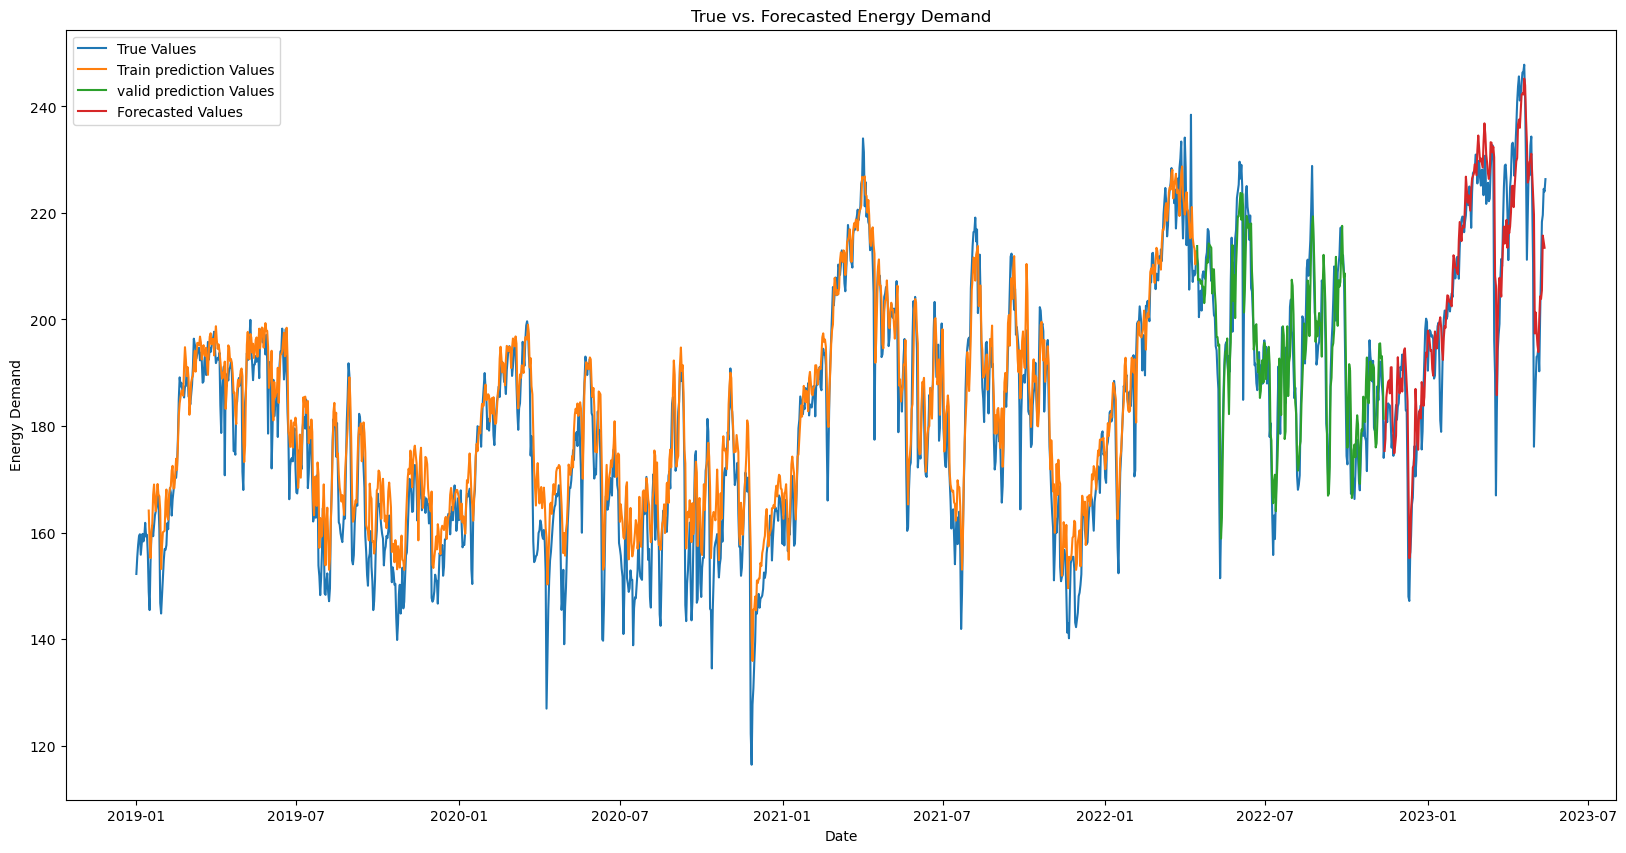

In [434]:
# predicting the training output and rescaling
train_forecast = multivariate_mlp.predict(X_train)
train_forecast_inverse = scaler_y.inverse_transform(train_forecast)

#predicting the validation output and rescaling
valid_forecast = multivariate_mlp.predict(X_val)
valid_forecast_inverse = scaler_y.inverse_transform(valid_forecast)

start_idx = X_train.shape[0]+X_val.shape[0]+X_test.shape[0]+1
end_idx = start_idx+ past_history
#preparing the test set for future day ahead forecast
X_test2 = scaler_X.transform(X[start_idx:end_idx,:])
X_test2 = X_test2.reshape(1,past_history,n_features)
#prediction using the trained model
forecast_unseen = multivariate_mlp.predict(X_test2)
forecast_unseen_inverse = scaler_y.inverse_transform(forecast_unseen)
print("Unseen data forecast :",forecast_unseen_inverse)


# Assuming merged_df is your DataFrame with the date column set as the index
true_values = merged_df['Energy Required (MU)'].values

# Create arrays for the x-axis (dates)
dates_true = merged_df.index[:len(merged_df)]
dates_train_pred = merged_df.index[past_history:train_end_idx]
dates_valid_pred = merged_df.index[train_end_idx:cv_end_idx]
dates_forecasted = merged_df.index[cv_end_idx:test_end_idx]
dates_unseen = merged_df.index[start_idx:end_idx]


# Plotting the true values and forecasted values
plt.figure(figsize=(20, 10))
plt.plot(dates_true, true_values[:len(merged_df)], label='True Values')
plt.plot(dates_train_pred, train_forecast_inverse, label='Train prediction Values')
plt.plot(dates_valid_pred, valid_forecast_inverse, label='valid prediction Values')
plt.plot(dates_forecasted, multivariate_mlp_forecast, label='Forecasted Values')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('True vs. Forecasted Energy Demand')
plt.legend()

'''# Adding another plot for unseen predictions
plt.figure(figsize=(12, 6))
plt.plot(dates_unseen, forecasted_values[161:], label='Unseen Predictions')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('Unseen Predictions')
plt.legend()'''

plt.show()


# **Encoder Decoder**

In [435]:
tf.keras.backend.clear_session()

encoder_decoder = tf.keras.models.Sequential([
    LSTM(50, activation='relu', input_shape=input_shape),
    RepeatVector(past_history),
    LSTM(50, activation='relu', return_sequences=True),
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(25, activation='relu'),
    Dense(1)
])



model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'encoder_decoder.h5', save_best_only=True)

optimizer = tf.keras.optimizers.Adam(lr=1e-3, amsgrad=True)

encoder_decoder.compile(loss=loss,
                    optimizer=optimizer,
                    metrics=metric)

In [436]:
history = encoder_decoder.fit(train, epochs=120,
                              validation_data=validation,
                              callbacks=[early_stopping, 
                                         model_checkpoint])

Epoch 1/120
38/38 [==============================] - 5s 31ms/step - loss: 0.0349 - root_mean_squared_error: 0.1758 - val_loss: 0.0259 - val_root_mean_squared_error: 0.1608
Epoch 2/120
38/38 [==============================] - 1s 19ms/step - loss: 0.0070 - root_mean_squared_error: 0.0836 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1136
Epoch 3/120
38/38 [==============================] - 1s 20ms/step - loss: 0.0063 - root_mean_squared_error: 0.0795 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1049
Epoch 4/120
38/38 [==============================] - 1s 19ms/step - loss: 0.0064 - root_mean_squared_error: 0.0802 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1071
Epoch 5/120
38/38 [==============================] - 1s 19ms/step - loss: 0.0059 - root_mean_squared_error: 0.0770 - val_loss: 0.0170 - val_root_mean_squared_error: 0.1302
Epoch 6/120
38/38 [==============================] - 1s 20ms/step - loss: 0.0066 - root_mean_squared_error: 0.0814 - val_loss: 0.0105 - val_

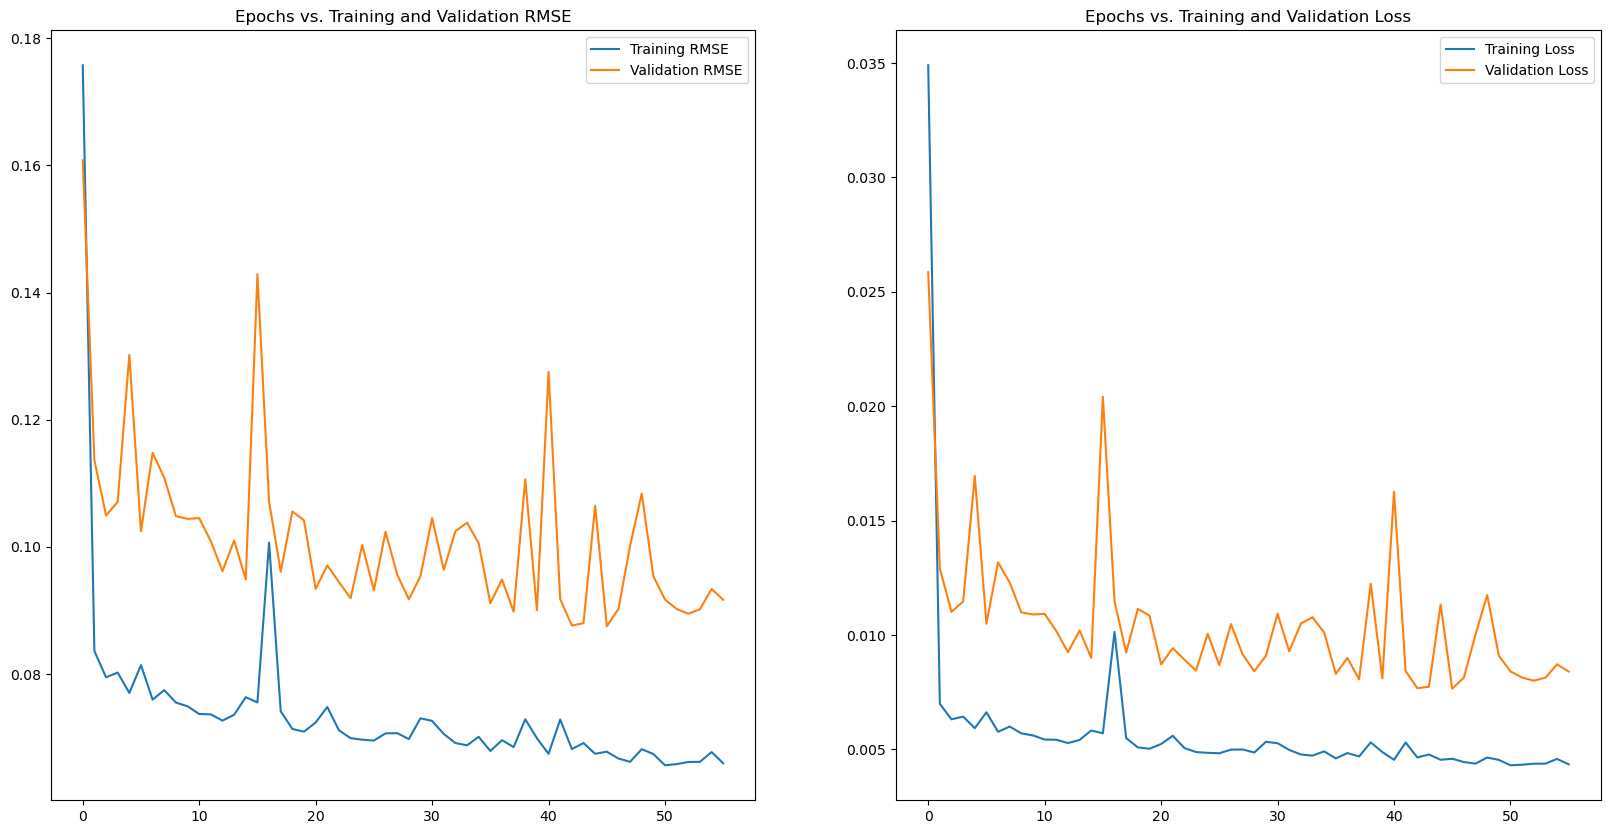

In [437]:
plot_model_rmse_and_loss(history)

In [438]:
encoder_decoder = tf.keras.models.load_model('encoder_decoder.h5')

forecast = encoder_decoder.predict(X_test)
encoder_decoder_forecast = scaler_y.inverse_transform(forecast)
rmse_encoder_decoder = sqrt(mean_squared_error(y_test_inv, 
                                               encoder_decoder_forecast))
print('RMSE of day ahead power demand Encoder-Decoder forecast: {}'
      .format(round(rmse_encoder_decoder, 3)))

6/6 [==============================] - 0s 6ms/step
RMSE of day ahead power demand Encoder-Decoder forecast: 10.858


1/1 [==============================] - 0s 22ms/step
Unseen data forecast : [[226.55582]]


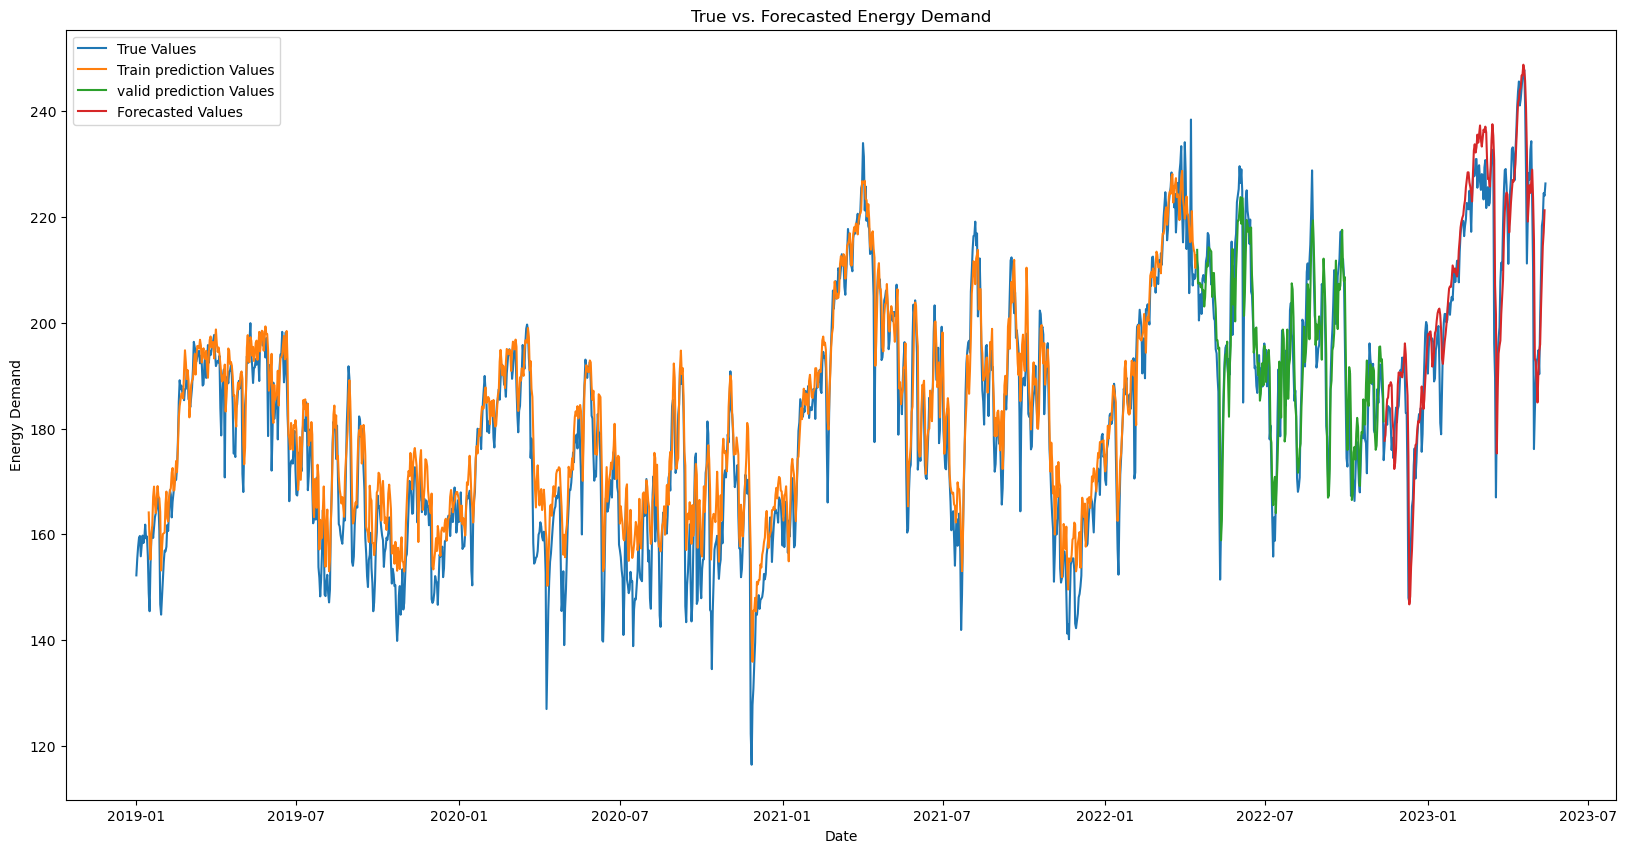

In [441]:
# predicting the training output and rescaling
train_forecast = multivariate_mlp.predict(X_train)
train_forecast_inverse = scaler_y.inverse_transform(train_forecast)

#predicting the validation output and rescaling
valid_forecast = multivariate_mlp.predict(X_val)
valid_forecast_inverse = scaler_y.inverse_transform(valid_forecast)

#start and end indices for the X_test2 
start_idx = X_train.shape[0]+X_val.shape[0]+X_test.shape[0]+1
end_idx = start_idx+ past_history

#preparing the test set for future day ahead forecast
X_test2 = scaler_X.transform(X[start_idx:end_idx,:])
X_test2 = X_test2.reshape(1,past_history,n_features)

#prediction using the trained model
forecast_unseen = multivariate_mlp.predict(X_test2)
forecast_unseen_inverse = scaler_y.inverse_transform(forecast_unseen)
print("Unseen data forecast :",forecast_unseen_inverse)


# true energy demand values
true_values = merged_df['Energy Required (MU)'].values

# Create arrays for the x-axis (dates)
dates_true = merged_df.index[:len(merged_df)]
dates_train_pred = merged_df.index[past_history:train_end_idx]
dates_valid_pred = merged_df.index[train_end_idx:cv_end_idx]
dates_forecasted = merged_df.index[cv_end_idx:test_end_idx]
dates_unseen = merged_df.index[start_idx:end_idx]


# Plotting the true values and forecasted values
plt.figure(figsize=(20, 10))
plt.plot(dates_true, true_values[:len(merged_df)], label='True Values')
plt.plot(dates_train_pred, train_forecast_inverse, label='Train prediction Values')
plt.plot(dates_valid_pred, valid_forecast_inverse, label='valid prediction Values')
plt.plot(dates_forecasted, encoder_decoder_forecast, label='Forecasted Values')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('True vs. Forecasted Energy Demand')
plt.legend()

'''# Adding another plot for unseen predictions
plt.figure(figsize=(12, 6))
plt.plot(dates_unseen, forecasted_values[161:], label='Unseen Predictions')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('Unseen Predictions')
plt.legend()'''

plt.show()


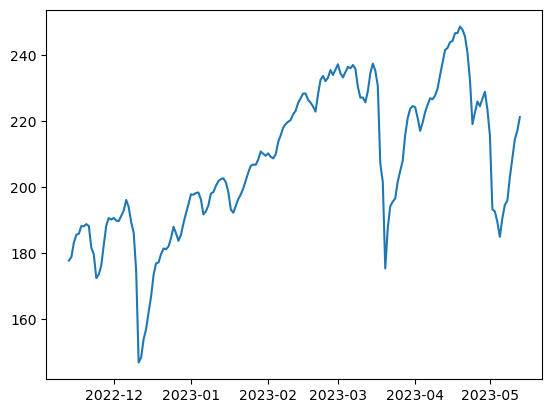

In [440]:
plt.plot(dates_forecasted,encoder_decoder_forecast, label='Forecasted Values') 

In [507]:
merged_df[:-1]

Energy Required (MU)       Tmax       Tmin      Rain  Day
2019-01-01               152.233  28.696802  14.070121  0.000000    1
2019-01-02               155.343  29.149151  14.778795  0.000000    2
2019-01-03               157.659  29.741541  15.863366  0.000000    3
2019-01-04               159.317  29.451434  16.492335  0.000000    4
2019-01-05               159.691  28.863384  16.951641  0.000000    5
...                          ...        ...        ...       ...  ...
2023-05-07               209.127  36.793343  26.633903  1.808096    1
2023-05-08               218.349  37.245505  26.819468  0.293171    2
2023-05-09               219.604  37.272888  27.273576  0.000000    3
2023-05-10               224.523  38.218507  26.842811  0.814892    4
2023-05-11               224.030  38.145824  27.398606  0.000000    5

[1592 rows x 5 columns]